<a href="https://colab.research.google.com/github/SicilianoBartolomeo/Human-activity-recognition/blob/main/HAR2_WISDM_smartphone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from operator import imod
import pandas as pd
import numpy as np
import tensorflow as tf
import keras as krs
from keras import Sequential
from keras.layers import Flatten, Dense, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPool2D, Conv1D, Bidirectional, LSTM
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
import seaborn
from sklearn.model_selection import train_test_split
from keras import backend as K
from sklearn.preprocessing import MinMaxScaler, RobustScaler

In [2]:
import random
seed=42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [3]:
from datetime import datetime


experiment_time = datetime.now().isoformat()
folder_name = str(experiment_time).replace(":","_")[0:19]
folder_name

configuration_file_name = 'configuration.txt'

In [4]:
dataset_path = 'Wisdm smartphone'
columns_names = ['user_id', 'activity', 'timestamp', 'x_axis', 'y_axis', 'z_axis']

In [5]:
X_column_names = ['x_axis','y_axis','z_axis']
y_column_name = 'activity'

In [6]:
time_steps_list = [600]
step_list =  [100]
use_magnitude = True
aggregate_falls = True
use_speed=False
use_total_speed=False
use_timestamp=False
use_squared_components=False
use_squared_speed=False
use_sign_speed=False
use_position=False

In [7]:
leave_one_subject_out = True
stratified_test_set = False
leave_one_subject_out_with_validation_users = False
bilstm_one_subject_out = True

use_stats_in_cnn=False

In [8]:
save_features = False

In [9]:
batchsize = 512

In [10]:
from os import mkdir
mkdir(folder_name)

In [11]:
config_file = open(folder_name + "/" + configuration_file_name,"a")
config_file.write("dataset: " + dataset_path +
"time_steps_list: " + str(time_steps_list) + 
"\nstep_list:" + str(step_list)+
"\nuse_magnitude: "+str(use_magnitude)+
"\naggregate_falls: "+str(aggregate_falls)+
"\nuse_speed: "+str(use_speed)+
"\nuse_total_speed: "+str(use_total_speed)+
"\nuse_timestamp: "+str(use_timestamp)+
"\nuse_squared_components: "+str(use_squared_components)+
"\nuse_squared_speed: "+str(use_squared_speed)+
"\nuse_sign_speed: "+str(use_sign_speed)+
"\nuse_position: "+str(use_position)
)
config_file.close()

# WISDM Dataset

In [12]:
classes_to_rename = {
    'A': 'walking',
    'B': 'jogging',
    'C': 'stairs',
    'D': 'sitting',
    'E': 'standing',
    'F': 'typing',
    'G': 'teeth',
    'H': 'soup',
    'I': 'chips',
    'J': 'pasta',
    'K': 'drinking',
    'L': 'sandwich',
    'M': 'kicking',
    'O': 'catch',
    'P': 'dribbling',
    'Q': 'writing',
    'R': 'clapping',
    'S': 'folding'
}

In [13]:
classes_to_consider = ['walking','jogging','stairs','sitting','standing','kicking']

In [14]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [15]:
df = pd.DataFrame()
#loop to combine all data
for i in range(1600,1650):

    df1 = pd.read_csv(f'/content/gdrive/My Drive/wisdm-dataset/raw/phone/accel/data_{i}_accel_phone.txt', header=None, sep=',')
    #df1 = df1.loc[:, [0,1,2,3,4,5]]
    df1 = df1.rename(columns={
         0: 'user_id', 1: 'activity', 2: 'timestamp',
             3:'x_axis', 4: 'y_axis', 5: 'z_axis'
        })
    df = pd.concat([df,df1])

In [16]:
df['z_axis'] = df['z_axis'].str.replace('\;*$', '', regex=True)
#df['z_axis'].apply(lambda x: float(x))
df['z_axis'] = df['z_axis'].astype(float)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1643619 entries, 0 to 71271
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   user_id    1643619 non-null  int64  
 1   activity   1643619 non-null  object 
 2   timestamp  1643619 non-null  int64  
 3   x_axis     1643619 non-null  float64
 4   y_axis     1643619 non-null  float64
 5   z_axis     1643619 non-null  float64
dtypes: float64(3), int64(2), object(1)
memory usage: 87.8+ MB


# Caricamento dati

In [ ]:
df = df.dropna()

In [ ]:
df.isnull().sum()

user_id      0
activity     0
timestamp    0
x_axis       0
y_axis       0
z_axis       0
dtype: int64

In [ ]:
df.head(10)

,user_id,activity,timestamp,x_axis,y_axis,z_axis
0,1600,A,252207666810782,-0.364761,8.793503,1.055084
1,1600,A,252207717164786,-0.879730,9.768784,1.016998
2,1600,A,252207767518790,2.001495,11.109070,2.619156
3,1600,A,252207817872794,0.450623,12.651642,0.184555
4,1600,A,252207868226798,-2.164352,13.928436,-4.422485
5,1600,A,252207918580802,-4.332779,13.361191,-0.718872
6,1600,A,252207968934806,-0.319443,13.318359,-0.232025
7,1600,A,252208019288809,1.566452,9.515274,-0.017776
8,1600,A,252208069642813,-0.323746,5.262665,0.322342
9,1600,A,252208119996817,-1.811676,3.710510,1.373932


In [ ]:
df.sample(10)

,user_id,activity,timestamp,x_axis,y_axis,z_axis
5897,1624,B,518603362098089,-3.095963,2.426041,-0.121399
61825,1603,O,9425217865252,-2.328361,2.385822,4.580108
86841,1642,L,1471510359086000,2.296824,7.429351,1.087339
43467,1635,E,678481160975257,-0.768616,-9.698090,0.019516
22138,1638,G,1138798539980058,-7.713220,-5.554249,2.990807
41147,1614,E,84103632280000,0.632285,9.917776,-3.365003
110044,1627,M,443210964771727,0.935974,-8.193619,-4.407074
114363,1635,P,676911779417001,-7.074707,-7.575470,2.004868
106374,1646,L,1466315476437000,-7.520361,-2.469265,-4.852310
33507,1600,J,254012019453013,2.465301,7.072983,5.613831


In [ ]:
df.describe()

,user_id,timestamp,x_axis,y_axis,z_axis
count,4.643624e+06,4.643624e+06,4.643624e+06,4.643624e+06,4.643624e+06
mean,1.626835e+03,6.042678e+14,3.086481e-01,-1.576753e+00,4.291402e-01
std,1.466014e+01,5.355812e+14,5.810945e+00,6.940320e+00,5.137941e+00
min,1.600000e+03,2.681027e+11,-7.847761e+01,-7.847761e+01,-7.847761e+01
25%,1.614000e+03,1.684410e+14,-3.662530e+00,-7.424530e+00,-2.768643e+00
50%,1.627000e+03,4.610860e+14,2.526474e-01,-1.810914e+00,1.060562e-01
75%,1.641000e+03,1.131446e+15,4.519165e+00,2.793003e+00,4.272343e+00
max,1.649000e+03,1.819803e+15,7.847761e+01,6.441166e+01,6.908195e+01


In [17]:
df['activity']=df['activity'].apply(lambda x: classes_to_rename[x] if x in classes_to_rename.keys() else x)

In [18]:
df = df[df['activity'].isin(classes_to_consider)]
df.reset_index(drop=True, inplace=True)

In [ ]:
df['activity'].unique()

array(['walking', 'jogging', 'stairs', 'sitting', 'standing', 'kicking'],
      dtype=object)

In [ ]:
df.sample(10)

,user_id,activity,timestamp,x_axis,y_axis,z_axis
3099650,1636,sandwich,503833648567297,0.325867,-9.075012,2.850693
4051808,1645,teeth,1129990502433000,8.552615,-2.715952,-4.176914
2566296,1629,kicking,1127840060660699,-2.827286,3.309464,-6.459183
2758555,1632,kicking,6314639972596,2.541779,-7.433533,-1.406753
1485600,1618,dribbling,775922595142645,-7.466431,-6.994934,0.345200
4329572,1647,stairs,1217936669543511,3.527856,-7.888296,-1.228225
802256,1610,kicking,19163981775701,9.033112,7.601898,4.990890
4201908,1646,standing,1464516788205000,-8.873548,-0.196392,-3.343447
2997976,1635,chips,678946613231862,-7.206222,0.794189,6.158997
3638312,1642,kicking,1472088429390000,-1.875300,9.932146,1.032253


In [ ]:
import math

if use_magnitude:
    df['magnitude'] = np.sqrt(np.power(df['x_axis'],2) + np.power(df['y_axis'],2) + np.power(df['z_axis'],2))
    X_column_names.append('magnitude')
df.sample(10)

,user_id,activity,timestamp,x_axis,y_axis,z_axis,magnitude
1535303,1648,kicking,460699311161000,-0.641865,-9.290281,-1.101709,9.377370
634319,1623,kicking,2913735675053,-2.702805,-8.200256,-4.293488,9.642789
1260939,1643,stairs,709905684882000,0.122146,-10.667418,-2.840493,11.039797
25489,1601,walking,265234998512947,-2.339135,-0.225055,-3.966594,4.610430
462239,1617,jogging,269209066926562,-7.390472,-8.189285,-9.196548,14.361754
1138887,1640,standing,169940051209782,9.482984,1.719635,-1.673996,9.781942
353767,1614,walking,81414898633000,-4.581673,4.569697,3.549419,7.380531
1500205,1648,jogging,460015535288000,5.982759,4.052373,-13.582156,15.384736
666095,1625,jogging,707639697012325,-7.157333,-1.654770,-3.338821,8.069288
1181539,1641,standing,1215595348079000,9.752520,-1.745969,0.596360,9.925508


In [19]:
classes = df['activity'].unique()
classes

array(['walking', 'jogging', 'stairs', 'sitting', 'standing', 'kicking'],
      dtype=object)

In [ ]:
if use_speed:
    records = []

    for index, row in df.iterrows():
        record = dict()
        if index==0 or (row['activity'])!=(df.iloc[index-1]['activity']):
            record['id']=index
            record['timestamp']=row['timestamp']
            record['v_x']=0
            record['v_y']=0
            record['v_z']=0
            record['x']=0
            record['y']=0
            record['z']=0
            record['v']=0
        else:
            prev_row = df.iloc[index-1]
            prev_record = records[-1]
            delta_t=(float(row['timestamp'])-float(prev_row['timestamp']))/1000
            record['id']=index
            record['timestamp']=row['timestamp']
            vx=float(prev_record['v_x'])+float(prev_row['x_axis'])*delta_t
            vy=float(prev_record['v_y'])+float(prev_row['y_axis'])*delta_t
            vz=float(prev_record['v_z'])+float(prev_row['z_axis'])*delta_t
            record['v_x']=vx
            record['v_y']=vy
            record['v_z']=vz
            x = float(prev_record['x']) + float(prev_record['v_x'])*delta_t + 0.5*float(prev_row['x_axis'])*(delta_t*delta_t)
            y = float(prev_record['x']) + float(prev_record['v_y'])*delta_t + 0.5*float(prev_row['y_axis'])*(delta_t*delta_t)
            z = float(prev_record['x']) + float(prev_record['v_z'])*delta_t + 0.5*float(prev_row['z_axis'])*(delta_t*delta_t)
            record['x']=x
            record['y']=y
            record['z']=z
            record['v']=np.sqrt(np.power(vx,2) + np.power(vy,2) + np.power(vz,2))
        records.append(record)

    df_velocità = pd.DataFrame(records, columns=['id','v_x','v_y','v_z','v','x','y','z'])
    df = pd.concat([df, df_velocità], axis=1).drop(columns=['id'])
    X_column_names+=['v_x','v_y','v_z','v']
    if not use_total_speed:
        X_column_names.remove('v')
    if use_position:
        X_column_names+=['x','y','z']
    df_velocità.head()

In [ ]:
df.head()

,user_id,activity,timestamp,x_axis,y_axis,z_axis
0,1600,walking,252207666810782,-0.364761,8.793503,1.055084
1,1600,walking,252207717164786,-0.879730,9.768784,1.016998
2,1600,walking,252207767518790,2.001495,11.109070,2.619156
3,1600,walking,252207817872794,0.450623,12.651642,0.184555
4,1600,walking,252207868226798,-2.164352,13.928436,-4.422485


In [ ]:
if use_squared_components:
    df['x_axis_squared'] = np.square(df['x_axis'])
    df['y_axis_squared'] = np.square(df['y_axis'])
    df['z_axis_squared'] = np.square(df['z_axis'])
    X_column_names+=['x_axis_squared', 'y_axis_squared','z_axis_squared']

if use_squared_speed:
    df['vx2'] = np.square(df['v_x'])
    df['vy2'] = np.square(df['v_y'])
    df['vz2'] = np.square(df['v_z'])
    X_column_names+=['vx2','vy2','vz2']

if use_sign_speed:
    df['signvx']= np.sign(df['v_x'])  #df['v_x']/(np.abs(df['v_x'])+1)
    df['signvy']= np.sign(df['v_y'])  #df['v_y']/(np.abs(df['v_y'])+1)
    df['signvz']= np.sign(df['v_z'])  #df['v_z']/(np.abs(df['v_z'])+1)
    X_column_names+=['signvx','signvy','signvz']

In [20]:
users_ids = df['user_id'].unique()
users_number = len(users_ids)
print("Numero totale di utenti:",users_number)

Numero totale di utenti: 50


In [21]:
user_original_data = dict() #dict {user_id: dataframe_dati_utente_originali}
for users_id in users_ids:
    user_original_data[users_id]=df[df['user_id']==users_id]

In [ ]:
user_original_data.keys()

dict_keys([1600, 1601, 1602, 1603, 1604, 1605, 1606, 1607, 1608, 1609, 1610, 1611, 1612, 1613, 1614, 1615, 1616, 1617, 1618, 1619, 1620, 1621, 1622, 1623, 1624, 1625, 1626, 1627, 1628, 1629, 1630, 1631, 1632, 1633, 1634, 1635, 1636, 1637, 1638, 1639, 1640, 1641, 1642, 1643, 1644, 1645, 1646, 1647, 1648, 1649])

In [ ]:
user_original_data[1600]

,user_id,activity,timestamp,x_axis,y_axis,z_axis
0,1600,walking,252207666810782,-0.364761,8.793503,1.055084
1,1600,walking,252207717164786,-0.879730,9.768784,1.016998
2,1600,walking,252207767518790,2.001495,11.109070,2.619156
3,1600,walking,252207817872794,0.450623,12.651642,0.184555
4,1600,walking,252207868226798,-2.164352,13.928436,-4.422485
...,...,...,...,...,...,...
21431,1600,kicking,252720982335811,-0.707062,9.464676,2.117401
21432,1600,kicking,252721032689815,-1.014496,10.686264,2.465805
21433,1600,kicking,252721083043819,-0.545135,9.939346,2.895477
21434,1600,kicking,252721133397823,-2.275940,9.506668,-0.079102


In [22]:
from scipy import stats
def create_sliding_windows(data, time_steps=1, step=1):
  Xs = []
  for i in range(0, len(data) - time_steps, step):
    v = data.iloc[i: (i+time_steps)]
    

    Xs.append(v)
    
  return Xs

In [23]:
user_trials = dict() #dict {user id: lista di trial dell'utente}

for users_id in users_ids:
    original_data = user_original_data[users_id]
    original_data.reset_index(inplace=True)
    #troviamo gli indici dei record iniziale di ogni trial (timestamp=0)
    index_start_trial = [0]
    for index, row in original_data.iterrows():
        if index==0:
            continue
        #if int(row['activity'])!=int(original_data.iloc[index-1]['activity']):
        if (row['activity'])!=(original_data.iloc[index-1]['activity']):
           # print("ok")
            index_start_trial.append(index)
    trials = []
    for i in range(len(index_start_trial)-1):
        trials.append(original_data.iloc[index_start_trial[i]:index_start_trial[i+1]-1])
    trials.append(original_data.iloc[index_start_trial[len(index_start_trial)-1]:])
    user_trials[users_id]=trials

In [ ]:
user_trials[1600][2]

,index,user_id,activity,timestamp,x_axis,y_axis,z_axis
7146,7146,1600,stairs,246178874142123,-0.317841,7.314484,-0.900681
7147,7147,1600,stairs,246178924496127,-0.959015,9.508591,-0.198471
7148,7148,1600,stairs,246178974850131,-1.682770,10.899124,-0.230484
7149,7149,1600,stairs,246179025204135,-0.705627,8.246170,-0.037766
7150,7150,1600,stairs,246179075558139,-0.884354,7.639664,-0.769241
...,...,...,...,...,...,...,...
10713,10713,1600,stairs,246358486856654,-0.254501,12.737015,-1.850555
10714,10714,1600,stairs,246358537210658,-0.434784,12.906448,-3.187790
10715,10715,1600,stairs,246358587564662,-1.015243,13.062683,-5.838913
10716,10716,1600,stairs,246358637918666,-2.938339,11.423859,-4.525818


In [24]:
sliding_w_by_timestep=dict() #[timestep][steps][userid][indice trial][indice sliding window]

for time_steps in time_steps_list:
    sliding_w_by_step=dict()
    for step in step_list:
        user_sliding_windows = dict()  #[userid][indice trial][indice sliding window]
        for user_id in users_ids:
            user_trial_list = user_trials[user_id]
            num_trials = len(user_trial_list)  
            list_sliding_windows = []  
            for i in range(num_trials):
                trial = user_trial_list[i]
                sliding_window = create_sliding_windows(trial, time_steps, step)
                list_sliding_windows.append(sliding_window)
            user_sliding_windows[user_id]=list_sliding_windows    
        sliding_w_by_step[step]=user_sliding_windows
    sliding_w_by_timestep[time_steps]=sliding_w_by_step  

In [ ]:
trial

,index,user_id,activity,timestamp,x_axis,y_axis,z_axis
22561,1558727,1649,kicking,1165742545426000,-3.019687,4.700417,3.092112
22562,1558728,1649,kicking,1165742595426000,-3.019687,4.700417,3.092112
22563,1558729,1649,kicking,1165742654990271,-3.019687,4.700417,3.092112
22564,1558730,1649,kicking,1165742695041104,9.728240,-8.869320,-3.269282
22565,1558731,1649,kicking,1165742734802094,17.413628,-16.252440,-14.623784
...,...,...,...,...,...,...,...
27068,1563234,1649,kicking,1165922420235514,1.870470,-10.578780,0.635062
27069,1563235,1649,kicking,1165922461594265,2.045247,-10.960655,1.805228
27070,1563236,1649,kicking,1165922499708379,1.446098,-10.711659,0.810437
27071,1563237,1649,kicking,1165922539890566,-0.080804,-9.328408,-1.273117


In [ ]:
sliding_w_by_timestep[time_steps_list[0]][step_list[0]][1600][0][0]

,index,user_id,activity,timestamp,x_axis,y_axis,z_axis
0,0,1600,walking,252207666810782,-0.364761,8.793503,1.055084
1,1,1600,walking,252207717164786,-0.879730,9.768784,1.016998
2,2,1600,walking,252207767518790,2.001495,11.109070,2.619156
3,3,1600,walking,252207817872794,0.450623,12.651642,0.184555
4,4,1600,walking,252207868226798,-2.164352,13.928436,-4.422485
...,...,...,...,...,...,...,...
595,595,1600,walking,252237627460514,-1.842972,9.064987,3.332001
596,596,1600,walking,252237677814518,-2.254501,7.773560,0.183594
597,597,1600,walking,252237728168522,-4.835785,9.605942,-0.548447
598,598,1600,walking,252237778522526,-1.824539,7.210815,0.420486


In [25]:
df_aggregate_feature_by_timestep = dict()
axes = ['x_axis','y_axis','z_axis']

for time_steps in time_steps_list:
    df_aggregate_feature_by_step = dict()
    for step in step_list:
        df_aggregate_feature_by_user = []
        for user_id in users_ids:
            df_aggregate_feature_by_trial=dict()
            for trial in range(len(sliding_w_by_timestep[time_steps][step][user_id])):
                df_aggregate_feature_by_sliding_window = dict()
                for sliding_window in range(len(sliding_w_by_timestep[time_steps][step][user_id][trial])):
                    tupla = dict()
                    tupla['time_steps']=time_steps
                    tupla['step']=step
                    tupla['user_id']=user_id
                    tupla['trial']=trial
                    tupla['sliding_window']=sliding_window
                    tupla['activity']=sliding_w_by_timestep[time_steps][step][user_id][trial][sliding_window]['activity'].unique()[0]
                    
                    for axis in axes:
                        tupla[f'{axis}_mean']=sliding_w_by_timestep[time_steps][step][user_id][trial][sliding_window][axis].mean()
                        tupla[f'{axis}_devstd']=sliding_w_by_timestep[time_steps][step][user_id][trial][sliding_window][axis].std()
                        tupla[f'{axis}_power']=sliding_w_by_timestep[time_steps][step][user_id][trial][sliding_window][axis].pow(2).mean()                   
                    
                    
                    for k1, v1 in sliding_w_by_timestep[time_steps][step][user_id][trial][sliding_window][axes].cov().to_dict().items():
                        for k2, v2 in v1.items():
                            tupla[f"cov({k1},{k2})"]=v2

                    df_aggregate_feature_by_user.append(tupla)
                    
                    #df_aggregate_feature_by_sliding_window[sliding_window]=tupla
                #df_aggregate_feature_by_trial[trial]=df_aggregate_feature_by_sliding_window
            #df_aggregate_feature_by_user[user_id]=df_aggregate_feature_by_trial
        df_aggregate_feature_by_step[step]=pd.DataFrame(df_aggregate_feature_by_user)
    df_aggregate_feature_by_timestep[time_steps]=df_aggregate_feature_by_step


In [26]:
import itertools

if save_features:
    for config in itertools.product(time_steps_list, step_list):
        time_step = config[0]
        step = config[1]
        
        example_list = []
        data = sliding_w_by_timestep[time_step][step]
        for user_id in users_ids:
            for trial in range(len(data[user_id])):
                for sliding_window in range(len(data[user_id][trial])):
                    for index, row in data[user_id][trial][sliding_window].iterrows():
                        item = row.to_dict()
                        item.update({'trial':trial,'sliding_window':sliding_window})
                        example_list.append(item)
        example_df = pd.DataFrame(example_list, columns=['trial','sliding_window']+list(sliding_w_by_timestep[time_step][step][users_ids[0]][0][0].columns))
        example_df.drop(columns="index", inplace=True)
        example_df.to_csv(f"{dataset_path.split('.')[0]}_{time_step}_{step}.csv")

In [27]:
tuple_by_timestep=dict()
for time_steps in time_steps_list:
    tuple_by_step=dict()
    for step in step_list:
        tuple = dict()

        for user_id in users_ids:
            Xs = []
            ys = []
            for trial in range(len(sliding_w_by_timestep[time_steps][step][user_id])):
                for sliding_window in range(len(sliding_w_by_timestep[time_steps][step][user_id][trial])):
                    Xs.append(np.array(sliding_w_by_timestep[time_steps][step][user_id][trial][sliding_window][X_column_names]))
                    ys.append(np.array(sliding_w_by_timestep[time_steps][step][user_id][trial][sliding_window][y_column_name].unique()))
            tuple[user_id]=(Xs,ys)
        tuple_by_step[step]=tuple
    tuple_by_timestep[time_steps]=tuple_by_step        

In [28]:
ignore_columns = ['time_steps', 'step', 'user_id', 'trial', 'activity', 'sliding_window']

tuple_by_timestep_with_stats=dict()
for time_steps in time_steps_list:
    tuple_by_step=dict()
    for step in step_list:
        tuple = dict()
        actual_df_stats = df_aggregate_feature_by_timestep[time_steps][step]
        feature_columns = [col_name for col_name in list(actual_df_stats.columns.values) if not col_name in ignore_columns]
        for user_id in users_ids:
            Xs = []
            ys = []
            for trial in range(len(sliding_w_by_timestep[time_steps][step][user_id])):
                for sliding_window in range(len(sliding_w_by_timestep[time_steps][step][user_id][trial])):
                    raw_and_feature = np.array(sliding_w_by_timestep[time_steps][step][user_id][trial][sliding_window][X_column_names]).flatten().reshape(-1,1)
                    actual_row_stats = actual_df_stats.loc[(actual_df_stats['time_steps']==time_steps) & (actual_df_stats['step']==step) & (actual_df_stats['user_id']==user_id) & (actual_df_stats['trial']==trial) &(actual_df_stats['sliding_window']==sliding_window)]
                    aggregate_feature = np.array(actual_row_stats[feature_columns]).reshape(-1,1)
                    #aggregate_feature = np.array(list(df_aggregate_feature_by_timestep[time_steps][step][user_id][trial][sliding_window].values())[2:]).reshape(-1,1)
                    Xs.append(np.concatenate((raw_and_feature,aggregate_feature),axis=0))
                    ys.append(np.array(sliding_w_by_timestep[time_steps][step][user_id][trial][sliding_window][y_column_name].unique()))
            tuple[user_id]=(Xs,ys)
        tuple_by_step[step]=tuple
    tuple_by_timestep_with_stats[time_steps]=tuple_by_step     

In [29]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives/ (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
    
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# CNN

In [30]:
cnn_dir = folder_name + "\\cnn"
leave_one_subject_out_dir = "\\leave_one_subject_out"
leave_one_subject_out_with_validation_user_dir =  "\\leave_one_subject_out_with_validation_user"
stratified_dir = "\\stratified"
plot_dir = "\\plot"
result_filename = "\\result.csv"
config_filename = "\\config.txt"

mkdir(cnn_dir )


In [ ]:
def createCNN(input_size, output_size):
    model = Sequential()
    model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu', input_shape = input_size))
    model.add(Dropout(0.5))
    model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(Dropout(0.5))
    model.add(Conv2D(filters=16, kernel_size=3, padding='same', activation='relu'))
    model.add(Dropout(0.5))

    #model.add(MaxPooling1D(pool_size=3))
    model.add(Flatten())

    #model.add(LSTM(100))
    #model.add(Dropout(0.5))

    model.add(Dense(256, activation='relu'))    
    model.add(Dense(256, activation='relu'))  
    model.add(Dense(128, activation='relu')) 
    model.add(Dense(128, activation='relu')) 
    model.add(Dense(128, activation='relu')) 
    model.add(Dropout(0.2))
    model.add(Dense(output_size, activation='softmax'))
    model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics = ['accuracy',f1_m])

    cnn_config_file = open(cnn_dir+config_filename, "a")
    model.summary(print_fn=lambda x: cnn_config_file.write(x))
    cnn_config_file.close()
    
    return model

In [31]:
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
enc = enc.fit(np.array(classes).reshape(-1,1))

In [41]:
import gc
gc.collect()

44810

In [33]:
if use_stats_in_cnn:
    data_cnn = tuple_by_timestep_with_stats
else:
    data_cnn = tuple_by_timestep

## CNN - Leave One Subject Out

In [34]:
notConsider = [1601,1603,1607,1608,1609,1612,1613,1617,1618,1619,1620,1621,1622,1624,1628,1629,1633,1636,1637,1638,1639,1640,1642,1644,1648, 1626,1647]

[Errno 17] File exists: '2023-02-09T15_36_46\\cnn\\leave_one_subject_out'
600 100
Utente test:  1600
Training: x-> 11011 y-> 11011
Validation: x-> 2753 y-> 2753
Testing: x-> 180 y-> 180
Total: x-> 13944 y-> 13944
Epoch 1/100
87/87 [==============================] - 12s 45ms/step - loss: 1.1622 - accuracy: 0.4821 - f1_m: 0.4180 - val_loss: 0.8274 - val_accuracy: 0.6673 - val_f1_m: 0.5999
Epoch 2/100
87/87 [==============================] - 3s 37ms/step - loss: 0.7347 - accuracy: 0.6687 - f1_m: 0.6361 - val_loss: 0.8156 - val_accuracy: 0.6738 - val_f1_m: 0.6164
Epoch 3/100
87/87 [==============================] - 3s 37ms/step - loss: 0.6629 - accuracy: 0.7029 - f1_m: 0.6742 - val_loss: 0.7244 - val_accuracy: 0.6902 - val_f1_m: 0.6469
Epoch 4/100
87/87 [==============================] - 3s 36ms/step - loss: 0.6103 - accuracy: 0.7285 - f1_m: 0.7116 - val_loss: 0.6915 - val_accuracy: 0.7076 - val_f1_m: 0.6849
Epoch 5/100
87/87 [==============================] - 3s 38ms/step - loss: 0.5750 -

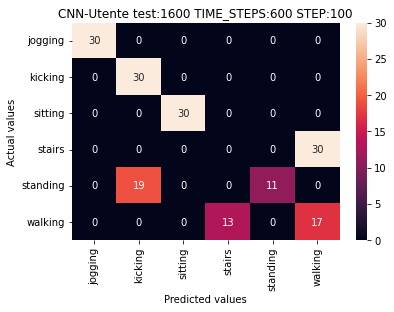

Utente test:  1602
Training: x-> 11011 y-> 11011
Validation: x-> 2753 y-> 2753
Testing: x-> 180 y-> 180
Total: x-> 13944 y-> 13944
Epoch 1/100
87/87 [==============================] - 4s 40ms/step - loss: 1.1949 - accuracy: 0.4667 - f1_m: 0.3952 - val_loss: 1.3011 - val_accuracy: 0.5721 - val_f1_m: 0.5454
Epoch 2/100
87/87 [==============================] - 3s 38ms/step - loss: 0.7117 - accuracy: 0.6673 - f1_m: 0.6454 - val_loss: 1.1244 - val_accuracy: 0.5721 - val_f1_m: 0.5191
Epoch 3/100
87/87 [==============================] - 3s 37ms/step - loss: 0.6204 - accuracy: 0.7085 - f1_m: 0.6990 - val_loss: 0.9039 - val_accuracy: 0.6408 - val_f1_m: 0.6441
Epoch 4/100
87/87 [==============================] - 3s 36ms/step - loss: 0.5269 - accuracy: 0.7712 - f1_m: 0.7591 - val_loss: 0.7338 - val_accuracy: 0.7080 - val_f1_m: 0.6843
Epoch 5/100
87/87 [==============================] - 3s 36ms/step - loss: 0.5171 - accuracy: 0.7908 - f1_m: 0.7807 - val_loss: 0.5555 - val_accuracy: 0.7839 - val_f1

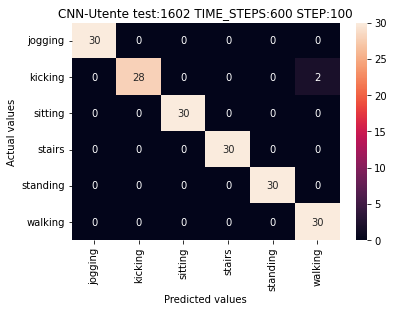

Utente test:  1604
Training: x-> 11011 y-> 11011
Validation: x-> 2753 y-> 2753
Testing: x-> 180 y-> 180
Total: x-> 13944 y-> 13944
Epoch 1/100
87/87 [==============================] - 4s 42ms/step - loss: 1.3685 - accuracy: 0.4027 - f1_m: 0.2970 - val_loss: 1.2934 - val_accuracy: 0.5289 - val_f1_m: 0.4963
Epoch 2/100
87/87 [==============================] - 3s 37ms/step - loss: 0.7790 - accuracy: 0.6404 - f1_m: 0.6149 - val_loss: 1.4628 - val_accuracy: 0.5830 - val_f1_m: 0.5203
Epoch 3/100
87/87 [==============================] - 3s 37ms/step - loss: 0.6592 - accuracy: 0.6981 - f1_m: 0.6816 - val_loss: 0.9583 - val_accuracy: 0.6418 - val_f1_m: 0.6016
Epoch 4/100
87/87 [==============================] - 3s 36ms/step - loss: 0.5858 - accuracy: 0.7405 - f1_m: 0.7275 - val_loss: 0.9717 - val_accuracy: 0.6052 - val_f1_m: 0.5860
Epoch 5/100
87/87 [==============================] - 3s 37ms/step - loss: 0.4809 - accuracy: 0.7926 - f1_m: 0.7856 - val_loss: 0.8110 - val_accuracy: 0.6858 - val_f1

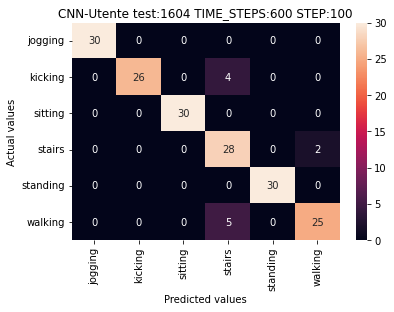

Utente test:  1605
Training: x-> 10963 y-> 10963
Validation: x-> 2741 y-> 2741
Testing: x-> 240 y-> 240
Total: x-> 13944 y-> 13944
Epoch 1/100
86/86 [==============================] - 5s 44ms/step - loss: 1.2315 - accuracy: 0.4543 - f1_m: 0.3773 - val_loss: 1.2066 - val_accuracy: 0.5845 - val_f1_m: 0.5401
Epoch 2/100
86/86 [==============================] - 3s 38ms/step - loss: 0.7188 - accuracy: 0.6666 - f1_m: 0.6474 - val_loss: 1.1817 - val_accuracy: 0.5728 - val_f1_m: 0.5804
Epoch 3/100
86/86 [==============================] - 3s 38ms/step - loss: 0.6097 - accuracy: 0.7274 - f1_m: 0.7105 - val_loss: 0.8628 - val_accuracy: 0.6753 - val_f1_m: 0.6564
Epoch 4/100
86/86 [==============================] - 3s 37ms/step - loss: 0.4805 - accuracy: 0.7980 - f1_m: 0.7879 - val_loss: 0.6373 - val_accuracy: 0.7351 - val_f1_m: 0.7212
Epoch 5/100
86/86 [==============================] - 3s 37ms/step - loss: 0.3971 - accuracy: 0.8373 - f1_m: 0.8345 - val_loss: 0.4524 - val_accuracy: 0.8103 - val_f1

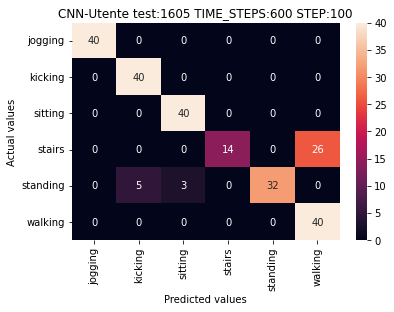

Utente test:  1606
Training: x-> 11011 y-> 11011
Validation: x-> 2753 y-> 2753
Testing: x-> 180 y-> 180
Total: x-> 13944 y-> 13944
Epoch 1/100
87/87 [==============================] - 4s 40ms/step - loss: 1.2363 - accuracy: 0.4607 - f1_m: 0.3640 - val_loss: 0.9993 - val_accuracy: 0.6186 - val_f1_m: 0.5738
Epoch 2/100
87/87 [==============================] - 3s 38ms/step - loss: 0.7680 - accuracy: 0.6499 - f1_m: 0.6188 - val_loss: 0.8785 - val_accuracy: 0.6560 - val_f1_m: 0.5949
Epoch 3/100
87/87 [==============================] - 3s 38ms/step - loss: 0.6392 - accuracy: 0.7106 - f1_m: 0.6861 - val_loss: 0.8954 - val_accuracy: 0.6201 - val_f1_m: 0.5897
Epoch 4/100
87/87 [==============================] - 3s 36ms/step - loss: 0.5610 - accuracy: 0.7525 - f1_m: 0.7350 - val_loss: 0.8926 - val_accuracy: 0.6375 - val_f1_m: 0.6241
Epoch 5/100
87/87 [==============================] - 3s 36ms/step - loss: 0.4586 - accuracy: 0.8051 - f1_m: 0.7963 - val_loss: 0.5352 - val_accuracy: 0.7999 - val_f1

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


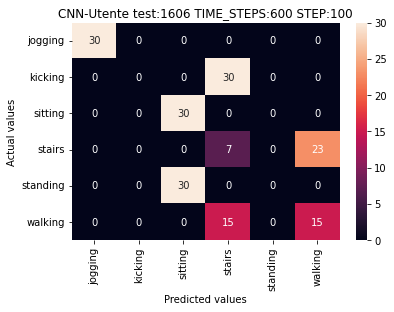

Utente test:  1610
Training: x-> 10964 y-> 10964
Validation: x-> 2741 y-> 2741
Testing: x-> 239 y-> 239
Total: x-> 13944 y-> 13944
Epoch 1/100
86/86 [==============================] - 5s 45ms/step - loss: 1.2017 - accuracy: 0.4703 - f1_m: 0.3837 - val_loss: 1.3819 - val_accuracy: 0.5527 - val_f1_m: 0.5359
Epoch 2/100
86/86 [==============================] - 3s 37ms/step - loss: 0.7398 - accuracy: 0.6539 - f1_m: 0.6281 - val_loss: 1.3037 - val_accuracy: 0.5910 - val_f1_m: 0.5293
Epoch 3/100
86/86 [==============================] - 3s 38ms/step - loss: 0.6507 - accuracy: 0.7014 - f1_m: 0.6788 - val_loss: 0.9644 - val_accuracy: 0.6640 - val_f1_m: 0.6217
Epoch 4/100
86/86 [==============================] - 3s 37ms/step - loss: 0.5761 - accuracy: 0.7422 - f1_m: 0.7247 - val_loss: 1.1041 - val_accuracy: 0.6487 - val_f1_m: 0.6132
Epoch 5/100
86/86 [==============================] - 3s 38ms/step - loss: 0.4923 - accuracy: 0.7929 - f1_m: 0.7831 - val_loss: 0.7942 - val_accuracy: 0.7008 - val_f1

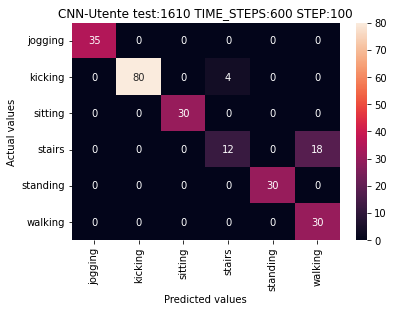

Utente test:  1611
Training: x-> 11011 y-> 11011
Validation: x-> 2753 y-> 2753
Testing: x-> 180 y-> 180
Total: x-> 13944 y-> 13944
Epoch 1/100
87/87 [==============================] - 4s 41ms/step - loss: 1.1990 - accuracy: 0.4741 - f1_m: 0.3936 - val_loss: 1.2078 - val_accuracy: 0.5064 - val_f1_m: 0.4929
Epoch 2/100
87/87 [==============================] - 3s 36ms/step - loss: 0.8851 - accuracy: 0.5993 - f1_m: 0.5646 - val_loss: 1.2477 - val_accuracy: 0.5812 - val_f1_m: 0.5443
Epoch 3/100
87/87 [==============================] - 3s 37ms/step - loss: 0.6652 - accuracy: 0.6933 - f1_m: 0.6709 - val_loss: 1.1737 - val_accuracy: 0.6331 - val_f1_m: 0.5987
Epoch 4/100
87/87 [==============================] - 3s 38ms/step - loss: 0.6030 - accuracy: 0.7250 - f1_m: 0.7050 - val_loss: 1.1922 - val_accuracy: 0.5954 - val_f1_m: 0.5693
Epoch 5/100
87/87 [==============================] - 3s 37ms/step - loss: 0.5445 - accuracy: 0.7628 - f1_m: 0.7459 - val_loss: 0.6862 - val_accuracy: 0.7167 - val_f1

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


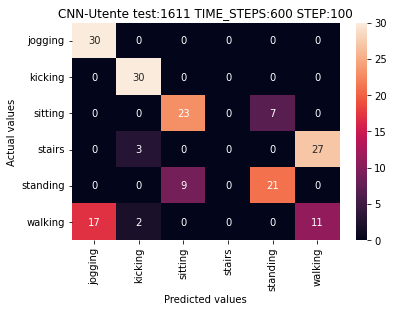

Utente test:  1614
Training: x-> 10747 y-> 10747
Validation: x-> 2687 y-> 2687
Testing: x-> 510 y-> 510
Total: x-> 13944 y-> 13944
Epoch 1/100
84/84 [==============================] - 5s 49ms/step - loss: 1.2542 - accuracy: 0.4475 - f1_m: 0.3583 - val_loss: 1.0185 - val_accuracy: 0.5869 - val_f1_m: 0.5130
Epoch 2/100
84/84 [==============================] - 3s 38ms/step - loss: 0.7206 - accuracy: 0.6648 - f1_m: 0.6414 - val_loss: 0.7285 - val_accuracy: 0.6595 - val_f1_m: 0.6135
Epoch 3/100
84/84 [==============================] - 3s 37ms/step - loss: 0.6303 - accuracy: 0.7071 - f1_m: 0.6909 - val_loss: 0.7665 - val_accuracy: 0.7019 - val_f1_m: 0.6566
Epoch 4/100
84/84 [==============================] - 3s 40ms/step - loss: 0.5242 - accuracy: 0.7633 - f1_m: 0.7517 - val_loss: 0.5241 - val_accuracy: 0.7994 - val_f1_m: 0.7791
Epoch 5/100
84/84 [==============================] - 3s 38ms/step - loss: 0.4333 - accuracy: 0.8161 - f1_m: 0.8122 - val_loss: 0.6768 - val_accuracy: 0.7201 - val_f1

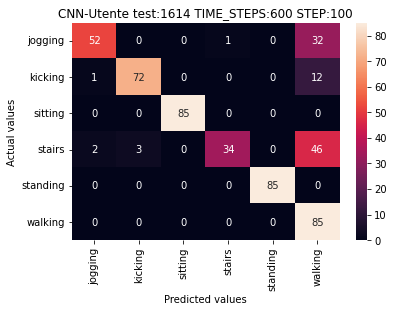

Utente test:  1615
Training: x-> 11011 y-> 11011
Validation: x-> 2753 y-> 2753
Testing: x-> 180 y-> 180
Total: x-> 13944 y-> 13944
Epoch 1/100
87/87 [==============================] - 4s 42ms/step - loss: 1.2399 - accuracy: 0.4577 - f1_m: 0.3628 - val_loss: 1.6470 - val_accuracy: 0.4054 - val_f1_m: 0.3632
Epoch 2/100
87/87 [==============================] - 3s 38ms/step - loss: 0.7329 - accuracy: 0.6678 - f1_m: 0.6407 - val_loss: 0.7824 - val_accuracy: 0.6520 - val_f1_m: 0.6091
Epoch 3/100
87/87 [==============================] - 3s 36ms/step - loss: 0.6242 - accuracy: 0.7186 - f1_m: 0.6954 - val_loss: 1.1675 - val_accuracy: 0.5692 - val_f1_m: 0.5300
Epoch 4/100
87/87 [==============================] - 3s 36ms/step - loss: 0.5836 - accuracy: 0.7495 - f1_m: 0.7318 - val_loss: 0.5411 - val_accuracy: 0.7926 - val_f1_m: 0.7567
Epoch 5/100
87/87 [==============================] - 3s 38ms/step - loss: 0.4529 - accuracy: 0.8146 - f1_m: 0.8094 - val_loss: 0.5068 - val_accuracy: 0.8242 - val_f1

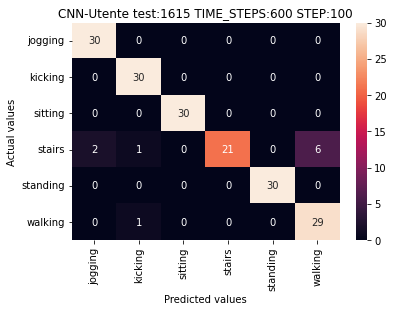

Utente test:  1616
Training: x-> 10911 y-> 10911
Validation: x-> 2728 y-> 2728
Testing: x-> 305 y-> 305
Total: x-> 13944 y-> 13944
Epoch 1/100
86/86 [==============================] - 4s 43ms/step - loss: 1.1658 - accuracy: 0.4904 - f1_m: 0.4184 - val_loss: 0.9571 - val_accuracy: 0.6008 - val_f1_m: 0.5782
Epoch 2/100
86/86 [==============================] - 3s 37ms/step - loss: 0.7073 - accuracy: 0.6794 - f1_m: 0.6580 - val_loss: 0.7226 - val_accuracy: 0.6994 - val_f1_m: 0.6704
Epoch 3/100
86/86 [==============================] - 3s 38ms/step - loss: 0.6152 - accuracy: 0.7266 - f1_m: 0.7075 - val_loss: 0.6023 - val_accuracy: 0.7306 - val_f1_m: 0.7304
Epoch 4/100
86/86 [==============================] - 3s 39ms/step - loss: 0.5394 - accuracy: 0.7639 - f1_m: 0.7520 - val_loss: 0.7586 - val_accuracy: 0.7573 - val_f1_m: 0.7165
Epoch 5/100
86/86 [==============================] - 3s 37ms/step - loss: 0.4336 - accuracy: 0.8227 - f1_m: 0.8134 - val_loss: 0.4058 - val_accuracy: 0.8453 - val_f1

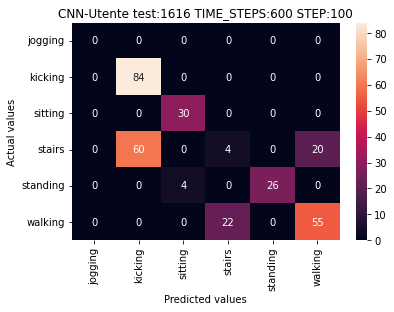

Utente test:  1623
Training: x-> 10968 y-> 10968
Validation: x-> 2742 y-> 2742
Testing: x-> 234 y-> 234
Total: x-> 13944 y-> 13944
Epoch 1/100
86/86 [==============================] - 5s 46ms/step - loss: 1.1863 - accuracy: 0.4865 - f1_m: 0.4010 - val_loss: 0.9154 - val_accuracy: 0.6163 - val_f1_m: 0.5914
Epoch 2/100
86/86 [==============================] - 3s 37ms/step - loss: 0.7150 - accuracy: 0.6780 - f1_m: 0.6445 - val_loss: 0.6524 - val_accuracy: 0.7020 - val_f1_m: 0.6637
Epoch 3/100
86/86 [==============================] - 3s 38ms/step - loss: 0.6072 - accuracy: 0.7332 - f1_m: 0.7183 - val_loss: 0.6969 - val_accuracy: 0.7425 - val_f1_m: 0.7117
Epoch 4/100
86/86 [==============================] - 3s 38ms/step - loss: 0.5069 - accuracy: 0.7970 - f1_m: 0.7919 - val_loss: 0.7393 - val_accuracy: 0.7203 - val_f1_m: 0.6947
Epoch 5/100
86/86 [==============================] - 3s 38ms/step - loss: 0.4315 - accuracy: 0.8259 - f1_m: 0.8224 - val_loss: 0.4766 - val_accuracy: 0.8115 - val_f1

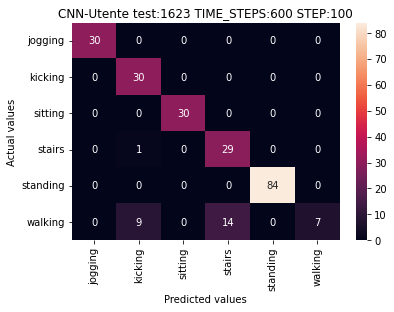

Utente test:  1625
Training: x-> 10814 y-> 10814
Validation: x-> 2704 y-> 2704
Testing: x-> 426 y-> 426
Total: x-> 13944 y-> 13944
Epoch 1/100
85/85 [==============================] - 4s 43ms/step - loss: 1.2268 - accuracy: 0.4589 - f1_m: 0.3693 - val_loss: 1.1172 - val_accuracy: 0.5766 - val_f1_m: 0.5297
Epoch 2/100
85/85 [==============================] - 3s 38ms/step - loss: 0.7706 - accuracy: 0.6449 - f1_m: 0.6170 - val_loss: 0.9382 - val_accuracy: 0.6516 - val_f1_m: 0.5955
Epoch 3/100
85/85 [==============================] - 3s 37ms/step - loss: 0.6506 - accuracy: 0.7031 - f1_m: 0.6892 - val_loss: 0.8750 - val_accuracy: 0.7101 - val_f1_m: 0.6628
Epoch 4/100
85/85 [==============================] - 3s 39ms/step - loss: 0.5665 - accuracy: 0.7568 - f1_m: 0.7398 - val_loss: 0.6822 - val_accuracy: 0.7611 - val_f1_m: 0.7227
Epoch 5/100
85/85 [==============================] - 3s 37ms/step - loss: 0.4421 - accuracy: 0.8222 - f1_m: 0.8150 - val_loss: 0.6390 - val_accuracy: 0.8036 - val_f1

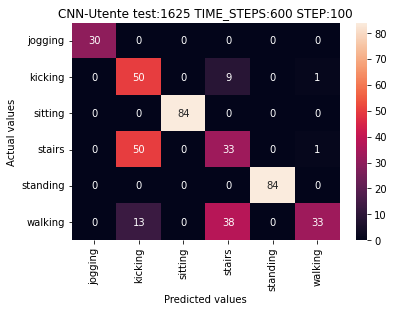

Utente test:  1627
Training: x-> 10796 y-> 10796
Validation: x-> 2699 y-> 2699
Testing: x-> 449 y-> 449
Total: x-> 13944 y-> 13944
Epoch 1/100
85/85 [==============================] - 4s 43ms/step - loss: 1.1422 - accuracy: 0.4954 - f1_m: 0.4308 - val_loss: 1.0295 - val_accuracy: 0.6095 - val_f1_m: 0.5739
Epoch 2/100
85/85 [==============================] - 3s 39ms/step - loss: 0.7432 - accuracy: 0.6687 - f1_m: 0.6384 - val_loss: 0.8455 - val_accuracy: 0.6684 - val_f1_m: 0.6123
Epoch 3/100
85/85 [==============================] - 3s 38ms/step - loss: 0.6241 - accuracy: 0.7240 - f1_m: 0.7067 - val_loss: 0.8421 - val_accuracy: 0.6380 - val_f1_m: 0.6500
Epoch 4/100
85/85 [==============================] - 3s 37ms/step - loss: 0.5535 - accuracy: 0.7677 - f1_m: 0.7518 - val_loss: 0.7074 - val_accuracy: 0.7151 - val_f1_m: 0.7068
Epoch 5/100
85/85 [==============================] - 3s 38ms/step - loss: 0.4373 - accuracy: 0.8216 - f1_m: 0.8164 - val_loss: 0.7642 - val_accuracy: 0.6606 - val_f1

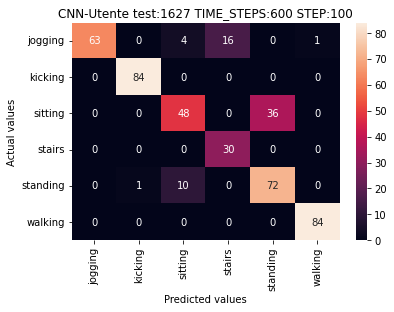

Utente test:  1630
Training: x-> 11011 y-> 11011
Validation: x-> 2753 y-> 2753
Testing: x-> 180 y-> 180
Total: x-> 13944 y-> 13944
Epoch 1/100
87/87 [==============================] - 5s 42ms/step - loss: 1.2165 - accuracy: 0.4624 - f1_m: 0.3789 - val_loss: 1.1606 - val_accuracy: 0.5979 - val_f1_m: 0.5587
Epoch 2/100
87/87 [==============================] - 3s 37ms/step - loss: 0.7135 - accuracy: 0.6711 - f1_m: 0.6519 - val_loss: 0.8698 - val_accuracy: 0.6190 - val_f1_m: 0.6378
Epoch 3/100
87/87 [==============================] - 3s 36ms/step - loss: 0.6002 - accuracy: 0.7272 - f1_m: 0.7123 - val_loss: 0.8305 - val_accuracy: 0.6190 - val_f1_m: 0.6312
Epoch 4/100
87/87 [==============================] - 3s 38ms/step - loss: 0.5449 - accuracy: 0.7611 - f1_m: 0.7473 - val_loss: 0.8383 - val_accuracy: 0.6658 - val_f1_m: 0.6536
Epoch 5/100
87/87 [==============================] - 3s 37ms/step - loss: 0.4319 - accuracy: 0.8191 - f1_m: 0.8151 - val_loss: 0.7134 - val_accuracy: 0.7261 - val_f1

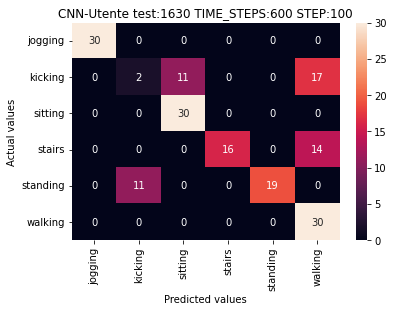

Utente test:  1631
Training: x-> 11011 y-> 11011
Validation: x-> 2753 y-> 2753
Testing: x-> 180 y-> 180
Total: x-> 13944 y-> 13944
Epoch 1/100
87/87 [==============================] - 4s 41ms/step - loss: 1.2053 - accuracy: 0.4609 - f1_m: 0.3878 - val_loss: 1.4672 - val_accuracy: 0.5478 - val_f1_m: 0.5166
Epoch 2/100
87/87 [==============================] - 3s 38ms/step - loss: 0.7411 - accuracy: 0.6718 - f1_m: 0.6385 - val_loss: 0.9728 - val_accuracy: 0.6477 - val_f1_m: 0.6027
Epoch 3/100
87/87 [==============================] - 3s 37ms/step - loss: 0.6219 - accuracy: 0.7217 - f1_m: 0.7073 - val_loss: 0.8918 - val_accuracy: 0.6411 - val_f1_m: 0.6047
Epoch 4/100
87/87 [==============================] - 3s 37ms/step - loss: 0.5286 - accuracy: 0.7752 - f1_m: 0.7645 - val_loss: 0.7764 - val_accuracy: 0.6952 - val_f1_m: 0.6689
Epoch 5/100
87/87 [==============================] - 3s 38ms/step - loss: 0.4348 - accuracy: 0.8287 - f1_m: 0.8175 - val_loss: 0.7178 - val_accuracy: 0.7287 - val_f1

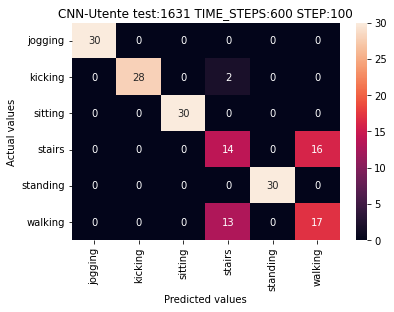

Utente test:  1632
Training: x-> 11011 y-> 11011
Validation: x-> 2753 y-> 2753
Testing: x-> 180 y-> 180
Total: x-> 13944 y-> 13944
Epoch 1/100
87/87 [==============================] - 5s 40ms/step - loss: 1.1866 - accuracy: 0.4719 - f1_m: 0.3967 - val_loss: 1.3098 - val_accuracy: 0.5202 - val_f1_m: 0.5068
Epoch 2/100
87/87 [==============================] - 3s 38ms/step - loss: 0.7481 - accuracy: 0.6546 - f1_m: 0.6202 - val_loss: 1.1863 - val_accuracy: 0.5543 - val_f1_m: 0.5362
Epoch 3/100
87/87 [==============================] - 3s 37ms/step - loss: 0.6779 - accuracy: 0.6968 - f1_m: 0.6720 - val_loss: 0.7109 - val_accuracy: 0.6869 - val_f1_m: 0.6464
Epoch 4/100
87/87 [==============================] - 3s 39ms/step - loss: 0.5763 - accuracy: 0.7454 - f1_m: 0.7311 - val_loss: 0.7510 - val_accuracy: 0.7152 - val_f1_m: 0.6698
Epoch 5/100
87/87 [==============================] - 3s 37ms/step - loss: 0.4914 - accuracy: 0.7908 - f1_m: 0.7838 - val_loss: 0.5480 - val_accuracy: 0.7868 - val_f1

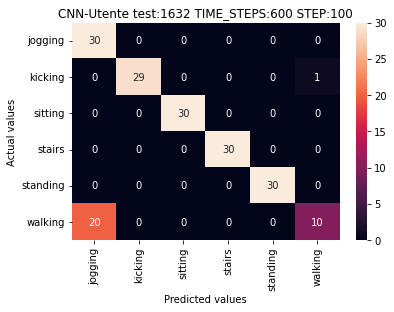

Utente test:  1634
Training: x-> 11011 y-> 11011
Validation: x-> 2753 y-> 2753
Testing: x-> 180 y-> 180
Total: x-> 13944 y-> 13944
Epoch 1/100
87/87 [==============================] - 4s 41ms/step - loss: 1.2074 - accuracy: 0.4587 - f1_m: 0.3806 - val_loss: 1.2647 - val_accuracy: 0.5717 - val_f1_m: 0.5291
Epoch 2/100
87/87 [==============================] - 3s 38ms/step - loss: 0.7294 - accuracy: 0.6602 - f1_m: 0.6292 - val_loss: 0.9950 - val_accuracy: 0.6146 - val_f1_m: 0.5696
Epoch 3/100
87/87 [==============================] - 3s 37ms/step - loss: 0.6026 - accuracy: 0.7260 - f1_m: 0.7123 - val_loss: 1.1233 - val_accuracy: 0.5837 - val_f1_m: 0.5908
Epoch 4/100
87/87 [==============================] - 3s 38ms/step - loss: 0.4970 - accuracy: 0.7988 - f1_m: 0.7892 - val_loss: 1.3540 - val_accuracy: 0.6070 - val_f1_m: 0.6085
Epoch 5/100
87/87 [==============================] - 3s 37ms/step - loss: 0.4303 - accuracy: 0.8304 - f1_m: 0.8259 - val_loss: 0.4918 - val_accuracy: 0.7940 - val_f1

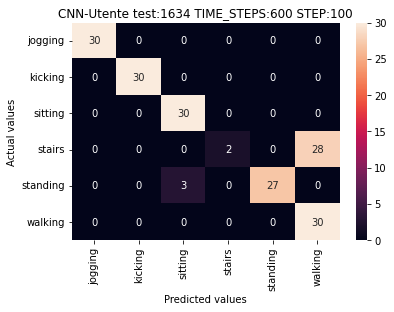

Utente test:  1635
Training: x-> 10752 y-> 10752
Validation: x-> 2688 y-> 2688
Testing: x-> 504 y-> 504
Total: x-> 13944 y-> 13944
Epoch 1/100
84/84 [==============================] - 4s 42ms/step - loss: 1.2982 - accuracy: 0.4395 - f1_m: 0.3196 - val_loss: 1.2579 - val_accuracy: 0.5439 - val_f1_m: 0.5047
Epoch 2/100
84/84 [==============================] - 3s 38ms/step - loss: 0.7713 - accuracy: 0.6458 - f1_m: 0.6143 - val_loss: 1.0953 - val_accuracy: 0.5844 - val_f1_m: 0.5639
Epoch 3/100
84/84 [==============================] - 3s 37ms/step - loss: 0.6631 - accuracy: 0.7051 - f1_m: 0.6775 - val_loss: 0.7615 - val_accuracy: 0.6949 - val_f1_m: 0.6381
Epoch 4/100
84/84 [==============================] - 3s 37ms/step - loss: 0.5682 - accuracy: 0.7539 - f1_m: 0.7399 - val_loss: 0.6915 - val_accuracy: 0.7526 - val_f1_m: 0.6959
Epoch 5/100
84/84 [==============================] - 3s 39ms/step - loss: 0.4731 - accuracy: 0.8063 - f1_m: 0.8012 - val_loss: 0.6429 - val_accuracy: 0.7619 - val_f1

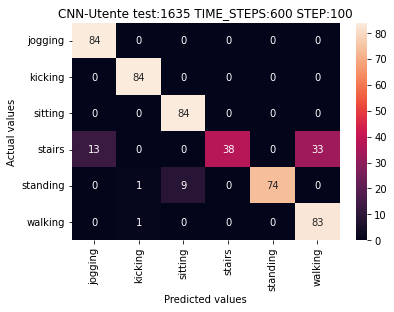

Utente test:  1641
Training: x-> 10752 y-> 10752
Validation: x-> 2688 y-> 2688
Testing: x-> 504 y-> 504
Total: x-> 13944 y-> 13944
Epoch 1/100
84/84 [==============================] - 4s 44ms/step - loss: 1.3386 - accuracy: 0.4139 - f1_m: 0.3157 - val_loss: 1.1932 - val_accuracy: 0.5387 - val_f1_m: 0.4653
Epoch 2/100
84/84 [==============================] - 3s 38ms/step - loss: 0.7741 - accuracy: 0.6482 - f1_m: 0.6144 - val_loss: 1.1813 - val_accuracy: 0.5606 - val_f1_m: 0.5432
Epoch 3/100
84/84 [==============================] - 3s 39ms/step - loss: 0.6233 - accuracy: 0.7147 - f1_m: 0.7008 - val_loss: 0.9309 - val_accuracy: 0.5986 - val_f1_m: 0.5826
Epoch 4/100
84/84 [==============================] - 3s 37ms/step - loss: 0.5309 - accuracy: 0.7700 - f1_m: 0.7557 - val_loss: 0.7907 - val_accuracy: 0.6953 - val_f1_m: 0.6749
Epoch 5/100
84/84 [==============================] - 3s 39ms/step - loss: 0.4149 - accuracy: 0.8272 - f1_m: 0.8239 - val_loss: 0.5780 - val_accuracy: 0.7630 - val_f1

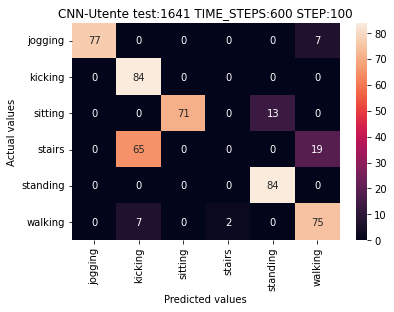

Utente test:  1643
Training: x-> 10752 y-> 10752
Validation: x-> 2688 y-> 2688
Testing: x-> 504 y-> 504
Total: x-> 13944 y-> 13944
Epoch 1/100
84/84 [==============================] - 4s 42ms/step - loss: 1.2333 - accuracy: 0.4657 - f1_m: 0.3656 - val_loss: 0.8748 - val_accuracy: 0.6183 - val_f1_m: 0.5712
Epoch 2/100
84/84 [==============================] - 3s 38ms/step - loss: 0.7225 - accuracy: 0.6643 - f1_m: 0.6447 - val_loss: 0.9278 - val_accuracy: 0.6551 - val_f1_m: 0.6206
Epoch 3/100
84/84 [==============================] - 3s 37ms/step - loss: 0.6338 - accuracy: 0.7118 - f1_m: 0.6977 - val_loss: 0.6742 - val_accuracy: 0.7228 - val_f1_m: 0.6855
Epoch 4/100
84/84 [==============================] - 3s 37ms/step - loss: 0.5094 - accuracy: 0.7840 - f1_m: 0.7711 - val_loss: 0.6381 - val_accuracy: 0.7712 - val_f1_m: 0.7535
Epoch 5/100
84/84 [==============================] - 3s 39ms/step - loss: 0.3945 - accuracy: 0.8389 - f1_m: 0.8367 - val_loss: 0.4786 - val_accuracy: 0.8344 - val_f1

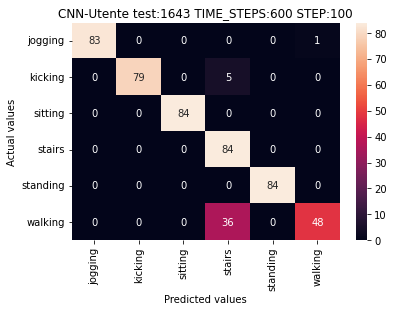

Utente test:  1645
Training: x-> 10752 y-> 10752
Validation: x-> 2688 y-> 2688
Testing: x-> 504 y-> 504
Total: x-> 13944 y-> 13944
Epoch 1/100
84/84 [==============================] - 4s 41ms/step - loss: 1.2539 - accuracy: 0.4497 - f1_m: 0.3612 - val_loss: 1.1387 - val_accuracy: 0.5945 - val_f1_m: 0.5388
Epoch 2/100
84/84 [==============================] - 3s 37ms/step - loss: 0.7115 - accuracy: 0.6651 - f1_m: 0.6421 - val_loss: 1.0000 - val_accuracy: 0.6135 - val_f1_m: 0.5918
Epoch 3/100
84/84 [==============================] - 3s 39ms/step - loss: 0.6100 - accuracy: 0.7131 - f1_m: 0.7017 - val_loss: 0.8384 - val_accuracy: 0.6406 - val_f1_m: 0.6338
Epoch 4/100
84/84 [==============================] - 3s 38ms/step - loss: 0.5460 - accuracy: 0.7611 - f1_m: 0.7459 - val_loss: 0.6970 - val_accuracy: 0.6741 - val_f1_m: 0.6890
Epoch 5/100
84/84 [==============================] - 3s 37ms/step - loss: 0.4571 - accuracy: 0.8074 - f1_m: 0.8012 - val_loss: 0.6809 - val_accuracy: 0.7388 - val_f1

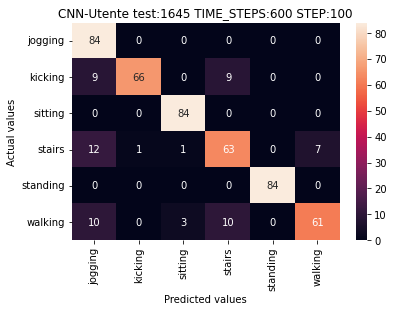

Utente test:  1646
Training: x-> 10752 y-> 10752
Validation: x-> 2688 y-> 2688
Testing: x-> 504 y-> 504
Total: x-> 13944 y-> 13944
Epoch 1/100
84/84 [==============================] - 4s 41ms/step - loss: 1.2221 - accuracy: 0.4612 - f1_m: 0.3762 - val_loss: 1.2250 - val_accuracy: 0.5320 - val_f1_m: 0.5150
Epoch 2/100
84/84 [==============================] - 3s 37ms/step - loss: 0.7204 - accuracy: 0.6677 - f1_m: 0.6375 - val_loss: 1.1936 - val_accuracy: 0.5967 - val_f1_m: 0.5955
Epoch 3/100
84/84 [==============================] - 3s 38ms/step - loss: 0.6081 - accuracy: 0.7255 - f1_m: 0.7091 - val_loss: 1.1265 - val_accuracy: 0.5446 - val_f1_m: 0.5562
Epoch 4/100
84/84 [==============================] - 3s 37ms/step - loss: 0.5217 - accuracy: 0.7692 - f1_m: 0.7556 - val_loss: 0.7095 - val_accuracy: 0.7266 - val_f1_m: 0.6968
Epoch 5/100
84/84 [==============================] - 3s 37ms/step - loss: 0.4040 - accuracy: 0.8318 - f1_m: 0.8263 - val_loss: 0.8950 - val_accuracy: 0.6875 - val_f1

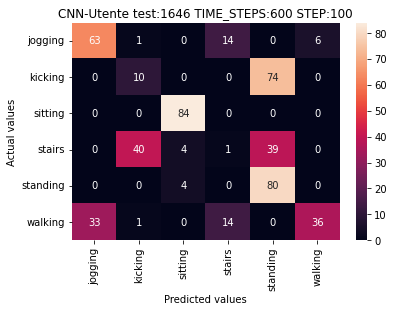

Utente test:  1649
Training: x-> 10963 y-> 10963
Validation: x-> 2741 y-> 2741
Testing: x-> 240 y-> 240
Total: x-> 13944 y-> 13944
Epoch 1/100
86/86 [==============================] - 4s 42ms/step - loss: 1.2044 - accuracy: 0.4614 - f1_m: 0.3797 - val_loss: 1.2723 - val_accuracy: 0.5713 - val_f1_m: 0.5240
Epoch 2/100
86/86 [==============================] - 3s 37ms/step - loss: 0.7204 - accuracy: 0.6786 - f1_m: 0.6469 - val_loss: 1.0672 - val_accuracy: 0.6410 - val_f1_m: 0.5968
Epoch 3/100
86/86 [==============================] - 3s 38ms/step - loss: 0.6434 - accuracy: 0.7093 - f1_m: 0.6915 - val_loss: 1.0829 - val_accuracy: 0.6498 - val_f1_m: 0.6200
Epoch 4/100
86/86 [==============================] - 3s 38ms/step - loss: 0.6103 - accuracy: 0.7250 - f1_m: 0.7080 - val_loss: 0.8069 - val_accuracy: 0.7041 - val_f1_m: 0.6647
Epoch 5/100
86/86 [==============================] - 3s 37ms/step - loss: 0.5250 - accuracy: 0.7702 - f1_m: 0.7541 - val_loss: 0.8144 - val_accuracy: 0.7114 - val_f1

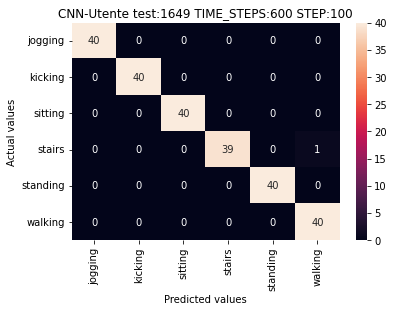

Accuracy media: 0.8075705869536643
F1 weighted media: 0.7869161590703145
F1 macro media: 0.7887951699782686
   Time Steps  Step  Average accuracy  Average F1 Weighted  Average F1 Macro  \
0         600   100          0.807571             0.786916          0.788795   

                                             reports  \
0  [              precision    recall  f1-score  ...   

                                    confusion_matrix  
0  [AxesSubplot(0.125,0.125;0.62x0.755), AxesSubp...  


In [ ]:
import itertools
import gc
from tabnanny import verbose
from tkinter import Y
batchsize=128

if leave_one_subject_out:
    cnn_results_dict = []
    cnn_results = pd.DataFrame()
    try:
        mkdir(cnn_dir + leave_one_subject_out_dir)
        mkdir(cnn_dir + leave_one_subject_out_dir + plot_dir)
    except OSError as error:
        print(error)

    for config in itertools.product(time_steps_list, step_list):

        time_step = config[0]
        step=config[1]

        cnn_f1_macro = []
        cnn_f1_weighted = []
        cnn_acc = []
        cnn_class_reports = []
        cnn_confusion_matrixes = []

        print(time_step,step)

        for user_id in users_ids:
            if user_id not in notConsider:

              print("Utente test: ", user_id)

              X_test = np.array(data_cnn[time_step][step][user_id][0])
              y_test = np.array(data_cnn[time_step][step][user_id][1])

              X_train = []
              y_train = []

              for id in users_ids:
                  if not id == user_id:
                      X_train += data_cnn[time_step][step][id][0]
                      y_train += data_cnn[time_step][step][id][1]
            
              X_train = np.array(X_train)
              y_train = np.array(y_train)

              scaler = RobustScaler()
              X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
              X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

              y_train = enc.transform(y_train)
              y_test = enc.transform(y_test)

              X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
              X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

      #      print(X_train)
       #     print(y_train)
        #    print(X_test)

         #   print(y_test)

              model = createCNN(X_train[0].shape, y_train[0].shape[0])

              callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

              XTraining, XValidation, YTraining, YValidation = train_test_split(X_train,y_train,stratify=y_train,test_size=0.2)

              print("Training: x->",len(XTraining),"y->",len(YTraining))
              print("Validation: x->",len(XValidation),"y->",len(YValidation))
              print("Testing: x->",len(X_test),"y->",len(y_test))
              print("Total: x->",len(XTraining)+len(XValidation)+len(X_test),"y->",len(YTraining)+len(YValidation)+len(y_test))

              model.fit(XTraining, YTraining, batch_size = batchsize, epochs = 100, validation_data=(XValidation,YValidation), verbose=1, callbacks=[callback], shuffle=True, workers=10, use_multiprocessing=True )

              rounded_labels=np.argmax(y_test, axis=1)
              y_pred = np.argmax(model.predict(X_test), axis=-1)

              cnn_acc.append(accuracy_score(rounded_labels, y_pred))
              cnn_f1_weighted.append(f1_score(rounded_labels, y_pred, average='weighted'))
              cnn_f1_macro.append(f1_score(rounded_labels, y_pred, average='macro'))
            #cnn_f1.append(f1_m(rounded_labels,y_pred))

              class_report = classification_report(rounded_labels, y_pred, digits=4)
              print(class_report)
              cnn_class_reports.append(class_report)
            
              conf_matrix = confusion_matrix(rounded_labels, y_pred, labels=range(0,len(enc.categories_[0])))

              ax = seaborn.heatmap(conf_matrix, annot=True, fmt='d')

              ax.set_title("CNN-Utente test:" + str(user_id) + " TIME_STEPS:"+str(time_step)+" STEP:"+str(step))

              ax.set_xlabel('Predicted values')
              ax.set_ylabel('Actual values')

              ax.xaxis.set_ticklabels(enc.categories_[0].tolist(), rotation=90)
              ax.yaxis.set_ticklabels(enc.categories_[0].tolist(), rotation=0)

              ax.get_figure().savefig(cnn_dir + leave_one_subject_out_dir + plot_dir +'/'+ax.get_title().replace(":"," ")+".png", dpi=500)
            #model_history_file=open(cnn_dir+'/'+ax.get_title().replace(":"," ")+".txt", "w")
            #model_history_file.write(model.history())
            #model_history_file.close()

              cnn_confusion_matrixes.append(ax)
              plt.show()

              gc.collect()            

        print("Accuracy media:",np.mean(cnn_acc))
        print("F1 weighted media:",np.mean(cnn_f1_weighted))
        print("F1 macro media:",np.mean(cnn_f1_macro))

        cnn_results_dict.append({
            'Time Steps':time_step,
            'Step':step,
            'Average accuracy':np.mean(cnn_acc),
            'Average F1 Weighted': np.mean(cnn_f1_weighted),
            'Average F1 Macro': np.mean(cnn_f1_macro),
            'reports':cnn_class_reports,
            'confusion_matrix':cnn_confusion_matrixes
        })
        
        cnn_results = pd.DataFrame(cnn_results_dict)
        print(cnn_results)
        cnn_results.to_csv(cnn_dir + leave_one_subject_out_dir + result_filename)


# Bi-LSTM

In [35]:
bilstm_dir = folder_name + "\\bilstm"
bilstm_plot_dir = bilstm_dir + "\\plot"
bilstm_result_filename = bilstm_dir + "\\result.csv"
bilstm_config_filename = bilstm_dir + "\\config_bilstm.txt"

mkdir(bilstm_dir)
mkdir(bilstm_plot_dir)

In [36]:
def createBiLSTM(input_size, output_size):
    model = Sequential()
    model.add(Bidirectional(LSTM(units=64, return_sequences=True, input_shape=input_size)))
    model.add(Dropout(rate=0.2))
    model.add(Bidirectional(LSTM(units=64)))
    model.add(Dropout(rate=0.2))

    model.add(Dense(units=64, activation='relu'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(output_size, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


    
    return model

In [37]:
data_cnn = tuple_by_timestep

600 100
Utente test:  1600
Epoch 1/100
22/22 [==============================] - 21s 309ms/step - loss: 1.6760 - accuracy: 0.2682 - val_loss: 1.5226 - val_accuracy: 0.3324
Epoch 2/100
22/22 [==============================] - 5s 241ms/step - loss: 1.5222 - accuracy: 0.3444 - val_loss: 1.3829 - val_accuracy: 0.4718
Epoch 3/100
22/22 [==============================] - 5s 246ms/step - loss: 1.3125 - accuracy: 0.4503 - val_loss: 1.1451 - val_accuracy: 0.5180
Epoch 4/100
22/22 [==============================] - 5s 244ms/step - loss: 1.3310 - accuracy: 0.4369 - val_loss: 1.2209 - val_accuracy: 0.4922
Epoch 5/100
22/22 [==============================] - 5s 249ms/step - loss: 1.2153 - accuracy: 0.4895 - val_loss: 1.0734 - val_accuracy: 0.5539
Epoch 6/100
22/22 [==============================] - 5s 242ms/step - loss: 1.1238 - accuracy: 0.5343 - val_loss: 1.0981 - val_accuracy: 0.5496
Epoch 7/100
22/22 [==============================] - 5s 242ms/step - loss: 1.1628 - accuracy: 0.5152 - val_loss: 1

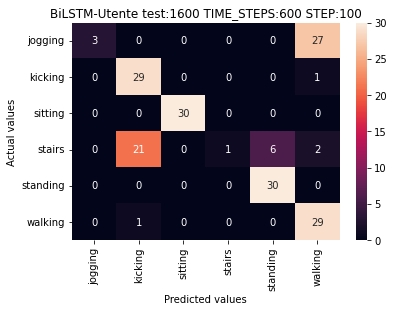

Utente test:  1602
Epoch 1/100
22/22 [==============================] - 15s 335ms/step - loss: 1.6770 - accuracy: 0.2628 - val_loss: 1.5389 - val_accuracy: 0.3222
Epoch 2/100
22/22 [==============================] - 5s 235ms/step - loss: 1.5404 - accuracy: 0.3260 - val_loss: 1.4689 - val_accuracy: 0.4076
Epoch 3/100
22/22 [==============================] - 5s 240ms/step - loss: 1.3969 - accuracy: 0.4169 - val_loss: 1.2105 - val_accuracy: 0.5176
Epoch 4/100
22/22 [==============================] - 5s 242ms/step - loss: 1.1983 - accuracy: 0.4975 - val_loss: 1.0487 - val_accuracy: 0.5714
Epoch 5/100
22/22 [==============================] - 5s 251ms/step - loss: 1.0941 - accuracy: 0.5501 - val_loss: 0.9776 - val_accuracy: 0.5946
Epoch 6/100
22/22 [==============================] - 6s 251ms/step - loss: 1.1157 - accuracy: 0.5448 - val_loss: 1.1821 - val_accuracy: 0.5336
Epoch 7/100
22/22 [==============================] - 5s 240ms/step - loss: 1.0542 - accuracy: 0.5627 - val_loss: 0.8721 - 

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0     0.5455    1.0000    0.7059        30
           1     0.0000    0.0000    0.0000        30
           2     1.0000    1.0000    1.0000        30
           3     0.0000    0.0000    0.0000        30
           4     1.0000    1.0000    1.0000        30
           5     0.4000    0.8667    0.5474        30

    accuracy                         0.6444       180
   macro avg     0.4909    0.6444    0.5422       180
weighted avg     0.4909    0.6444    0.5422       180



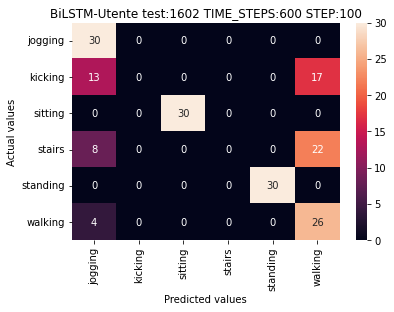

Utente test:  1604
Epoch 1/100
22/22 [==============================] - 15s 304ms/step - loss: 1.6923 - accuracy: 0.2685 - val_loss: 1.5421 - val_accuracy: 0.3516
Epoch 2/100
22/22 [==============================] - 5s 247ms/step - loss: 1.4924 - accuracy: 0.3765 - val_loss: 1.3923 - val_accuracy: 0.4348
Epoch 3/100
22/22 [==============================] - 5s 239ms/step - loss: 1.3136 - accuracy: 0.4551 - val_loss: 1.1444 - val_accuracy: 0.5380
Epoch 4/100
22/22 [==============================] - 6s 252ms/step - loss: 1.1558 - accuracy: 0.5220 - val_loss: 1.0254 - val_accuracy: 0.5627
Epoch 5/100
22/22 [==============================] - 6s 251ms/step - loss: 1.0784 - accuracy: 0.5574 - val_loss: 0.9763 - val_accuracy: 0.5906
Epoch 6/100
22/22 [==============================] - 5s 251ms/step - loss: 1.0474 - accuracy: 0.5763 - val_loss: 1.0514 - val_accuracy: 0.5507
Epoch 7/100
22/22 [==============================] - 6s 252ms/step - loss: 1.0142 - accuracy: 0.5728 - val_loss: 0.9015 - 

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        30
           1     0.3818    0.7000    0.4941        30
           2     1.0000    0.9667    0.9831        30
           3     1.0000    0.4000    0.5714        30
           4     1.0000    0.9000    0.9474        30
           5     0.0877    0.1667    0.1149        30

    accuracy                         0.5222       180
   macro avg     0.5783    0.5222    0.5185       180
weighted avg     0.5783    0.5222    0.5185       180



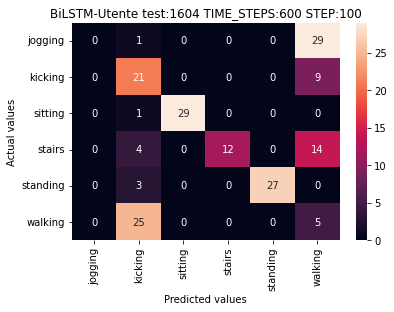

Utente test:  1605
Epoch 1/100
22/22 [==============================] - 15s 298ms/step - loss: 1.6787 - accuracy: 0.2604 - val_loss: 1.5488 - val_accuracy: 0.3134
Epoch 2/100
22/22 [==============================] - 5s 245ms/step - loss: 1.5102 - accuracy: 0.3550 - val_loss: 1.3477 - val_accuracy: 0.4301
Epoch 3/100
22/22 [==============================] - 5s 251ms/step - loss: 1.3115 - accuracy: 0.4540 - val_loss: 1.1849 - val_accuracy: 0.5192
Epoch 4/100
22/22 [==============================] - 5s 250ms/step - loss: 1.2194 - accuracy: 0.5000 - val_loss: 1.0870 - val_accuracy: 0.5389
Epoch 5/100
22/22 [==============================] - 5s 245ms/step - loss: 1.1118 - accuracy: 0.5377 - val_loss: 0.9774 - val_accuracy: 0.5939
Epoch 6/100
22/22 [==============================] - 5s 242ms/step - loss: 1.2311 - accuracy: 0.4996 - val_loss: 1.1346 - val_accuracy: 0.5195
Epoch 7/100
22/22 [==============================] - 5s 249ms/step - loss: 1.1434 - accuracy: 0.5281 - val_loss: 1.0209 - 

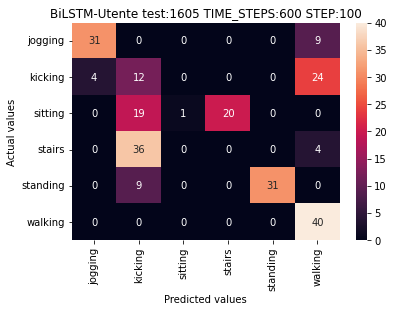

Utente test:  1606
Epoch 1/100
22/22 [==============================] - 15s 298ms/step - loss: 1.7001 - accuracy: 0.2621 - val_loss: 1.5556 - val_accuracy: 0.3447
Epoch 2/100
22/22 [==============================] - 5s 244ms/step - loss: 1.5337 - accuracy: 0.3420 - val_loss: 1.3980 - val_accuracy: 0.4548
Epoch 3/100
22/22 [==============================] - 5s 251ms/step - loss: 1.3088 - accuracy: 0.4543 - val_loss: 1.1322 - val_accuracy: 0.5398
Epoch 4/100
22/22 [==============================] - 5s 251ms/step - loss: 1.1779 - accuracy: 0.5178 - val_loss: 1.0197 - val_accuracy: 0.5685
Epoch 5/100
22/22 [==============================] - 6s 253ms/step - loss: 1.1032 - accuracy: 0.5532 - val_loss: 0.9831 - val_accuracy: 0.5993
Epoch 6/100
22/22 [==============================] - 5s 243ms/step - loss: 1.0271 - accuracy: 0.5802 - val_loss: 0.9437 - val_accuracy: 0.6070
Epoch 7/100
22/22 [==============================] - 5s 242ms/step - loss: 0.9830 - accuracy: 0.5868 - val_loss: 0.8606 - 

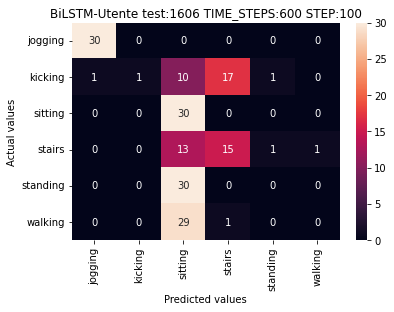

Utente test:  1610
Epoch 1/100
22/22 [==============================] - 16s 331ms/step - loss: 1.6971 - accuracy: 0.2688 - val_loss: 1.5284 - val_accuracy: 0.3619
Epoch 2/100
22/22 [==============================] - 5s 247ms/step - loss: 1.5277 - accuracy: 0.3488 - val_loss: 1.3878 - val_accuracy: 0.4469
Epoch 3/100
22/22 [==============================] - 5s 241ms/step - loss: 1.4313 - accuracy: 0.4173 - val_loss: 1.4043 - val_accuracy: 0.3885
Epoch 4/100
22/22 [==============================] - 6s 253ms/step - loss: 1.4159 - accuracy: 0.4086 - val_loss: 1.2402 - val_accuracy: 0.5053
Epoch 5/100
22/22 [==============================] - 5s 241ms/step - loss: 1.2893 - accuracy: 0.4673 - val_loss: 1.1820 - val_accuracy: 0.5462
Epoch 6/100
22/22 [==============================] - 5s 251ms/step - loss: 1.1749 - accuracy: 0.5158 - val_loss: 1.0217 - val_accuracy: 0.5728
Epoch 7/100
22/22 [==============================] - 5s 238ms/step - loss: 1.1614 - accuracy: 0.5269 - val_loss: 1.1454 - 

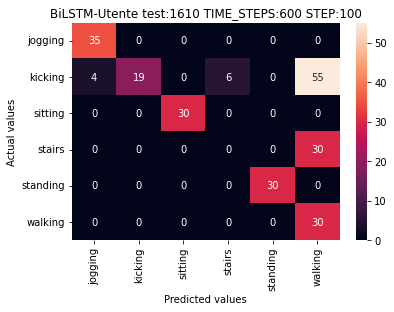

Utente test:  1611
Epoch 1/100
22/22 [==============================] - 15s 300ms/step - loss: 1.6856 - accuracy: 0.2634 - val_loss: 1.5344 - val_accuracy: 0.3127
Epoch 2/100
22/22 [==============================] - 5s 246ms/step - loss: 1.5340 - accuracy: 0.3323 - val_loss: 1.4381 - val_accuracy: 0.4130
Epoch 3/100
22/22 [==============================] - 6s 252ms/step - loss: 1.3829 - accuracy: 0.4254 - val_loss: 1.1925 - val_accuracy: 0.5049
Epoch 4/100
22/22 [==============================] - 6s 252ms/step - loss: 1.1763 - accuracy: 0.5228 - val_loss: 1.0345 - val_accuracy: 0.5696
Epoch 5/100
22/22 [==============================] - 6s 252ms/step - loss: 1.0760 - accuracy: 0.5565 - val_loss: 0.9198 - val_accuracy: 0.6015
Epoch 6/100
22/22 [==============================] - 6s 253ms/step - loss: 0.9891 - accuracy: 0.5959 - val_loss: 0.8927 - val_accuracy: 0.6320
Epoch 7/100
22/22 [==============================] - 5s 249ms/step - loss: 0.9191 - accuracy: 0.6247 - val_loss: 1.1018 - 

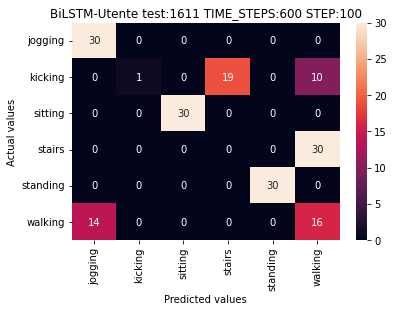

Utente test:  1614
Epoch 1/100
21/21 [==============================] - 15s 310ms/step - loss: 1.6757 - accuracy: 0.2693 - val_loss: 1.5339 - val_accuracy: 0.3316
Epoch 2/100
21/21 [==============================] - 5s 245ms/step - loss: 1.5182 - accuracy: 0.3540 - val_loss: 1.4091 - val_accuracy: 0.4559
Epoch 3/100
21/21 [==============================] - 5s 256ms/step - loss: 1.3250 - accuracy: 0.4471 - val_loss: 1.1142 - val_accuracy: 0.5288
Epoch 4/100
21/21 [==============================] - 5s 259ms/step - loss: 1.1954 - accuracy: 0.5050 - val_loss: 1.0913 - val_accuracy: 0.5579
Epoch 5/100
21/21 [==============================] - 5s 259ms/step - loss: 1.1063 - accuracy: 0.5398 - val_loss: 0.9856 - val_accuracy: 0.5832
Epoch 6/100
21/21 [==============================] - 5s 256ms/step - loss: 1.0666 - accuracy: 0.5611 - val_loss: 1.1170 - val_accuracy: 0.5906
Epoch 7/100
21/21 [==============================] - 5s 256ms/step - loss: 1.0076 - accuracy: 0.5870 - val_loss: 0.8245 - 

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0     0.0677    0.1059    0.0826        85
           1     0.8182    0.1059    0.1875        85
           2     1.0000    1.0000    1.0000        85
           3     0.0000    0.0000    0.0000        85
           4     1.0000    1.0000    1.0000        85
           5     0.3061    0.7059    0.4270        85

    accuracy                         0.4863       510
   macro avg     0.5320    0.4863    0.4495       510
weighted avg     0.5320    0.4863    0.4495       510



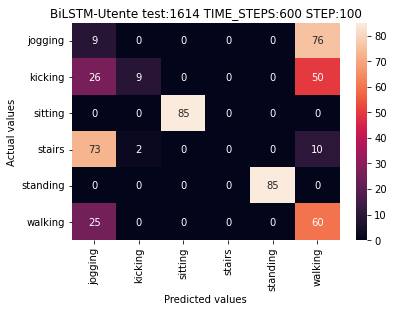

Utente test:  1615
Epoch 1/100
22/22 [==============================] - 16s 323ms/step - loss: 1.6942 - accuracy: 0.2641 - val_loss: 1.5424 - val_accuracy: 0.3229
Epoch 2/100
22/22 [==============================] - 5s 244ms/step - loss: 1.5413 - accuracy: 0.3261 - val_loss: 1.4235 - val_accuracy: 0.4188
Epoch 3/100
22/22 [==============================] - 5s 236ms/step - loss: 1.3887 - accuracy: 0.4234 - val_loss: 1.2068 - val_accuracy: 0.4740
Epoch 4/100
22/22 [==============================] - 5s 249ms/step - loss: 1.2192 - accuracy: 0.4898 - val_loss: 1.0266 - val_accuracy: 0.5808
Epoch 5/100
22/22 [==============================] - 5s 239ms/step - loss: 1.1980 - accuracy: 0.5079 - val_loss: 1.0360 - val_accuracy: 0.5997
Epoch 6/100
22/22 [==============================] - 5s 242ms/step - loss: 1.0867 - accuracy: 0.5568 - val_loss: 0.9215 - val_accuracy: 0.6211
Epoch 7/100
22/22 [==============================] - 5s 244ms/step - loss: 1.0134 - accuracy: 0.5797 - val_loss: 1.1212 - 

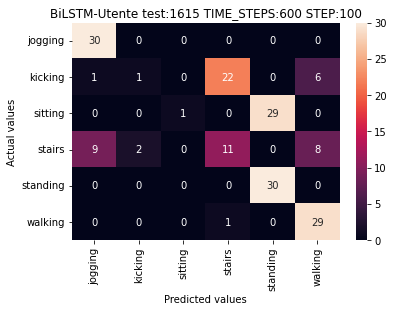

Utente test:  1616
Epoch 1/100
22/22 [==============================] - 15s 295ms/step - loss: 1.6852 - accuracy: 0.2743 - val_loss: 1.5230 - val_accuracy: 0.3336
Epoch 2/100
22/22 [==============================] - 5s 245ms/step - loss: 1.5214 - accuracy: 0.3459 - val_loss: 1.4091 - val_accuracy: 0.4322
Epoch 3/100
22/22 [==============================] - 5s 237ms/step - loss: 1.3669 - accuracy: 0.4441 - val_loss: 1.2062 - val_accuracy: 0.5286
Epoch 4/100
22/22 [==============================] - 5s 240ms/step - loss: 1.2001 - accuracy: 0.5044 - val_loss: 1.0640 - val_accuracy: 0.5762
Epoch 5/100
22/22 [==============================] - 6s 253ms/step - loss: 1.1380 - accuracy: 0.5310 - val_loss: 0.9763 - val_accuracy: 0.6081
Epoch 6/100
22/22 [==============================] - 5s 250ms/step - loss: 1.0489 - accuracy: 0.5709 - val_loss: 1.0783 - val_accuracy: 0.5572
Epoch 7/100
22/22 [==============================] - 5s 251ms/step - loss: 1.0644 - accuracy: 0.5615 - val_loss: 0.8856 - 

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


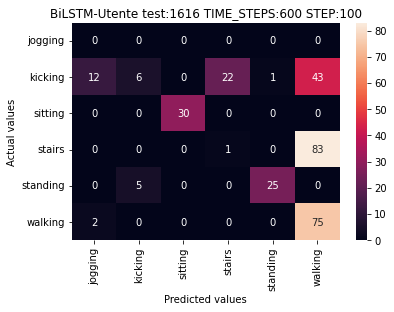

Utente test:  1623
Epoch 1/100
22/22 [==============================] - 15s 303ms/step - loss: 1.6974 - accuracy: 0.2697 - val_loss: 1.5323 - val_accuracy: 0.3647
Epoch 2/100
22/22 [==============================] - 5s 246ms/step - loss: 1.5111 - accuracy: 0.3613 - val_loss: 1.3453 - val_accuracy: 0.4318
Epoch 3/100
22/22 [==============================] - 5s 236ms/step - loss: 1.3550 - accuracy: 0.4339 - val_loss: 1.1964 - val_accuracy: 0.5168
Epoch 4/100
22/22 [==============================] - 5s 240ms/step - loss: 1.2472 - accuracy: 0.4750 - val_loss: 1.1783 - val_accuracy: 0.5368
Epoch 5/100
22/22 [==============================] - 6s 253ms/step - loss: 1.1902 - accuracy: 0.4977 - val_loss: 1.1076 - val_accuracy: 0.5522
Epoch 6/100
22/22 [==============================] - 5s 241ms/step - loss: 1.1008 - accuracy: 0.5509 - val_loss: 0.9786 - val_accuracy: 0.6025
Epoch 7/100
22/22 [==============================] - 6s 251ms/step - loss: 1.1277 - accuracy: 0.5445 - val_loss: 0.9931 - 

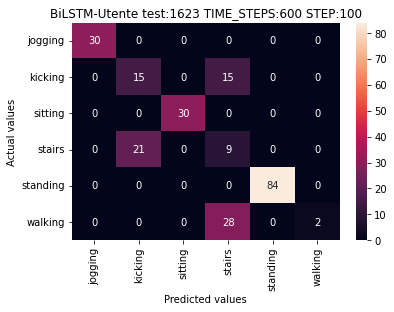

Utente test:  1625
Epoch 1/100
22/22 [==============================] - 15s 294ms/step - loss: 1.6801 - accuracy: 0.2743 - val_loss: 1.5062 - val_accuracy: 0.3413
Epoch 2/100
22/22 [==============================] - 5s 243ms/step - loss: 1.5480 - accuracy: 0.3317 - val_loss: 1.4403 - val_accuracy: 0.4201
Epoch 3/100
22/22 [==============================] - 5s 248ms/step - loss: 1.4145 - accuracy: 0.4057 - val_loss: 1.2405 - val_accuracy: 0.5085
Epoch 4/100
22/22 [==============================] - 5s 249ms/step - loss: 1.2889 - accuracy: 0.4661 - val_loss: 1.1439 - val_accuracy: 0.5270
Epoch 5/100
22/22 [==============================] - 5s 251ms/step - loss: 1.1837 - accuracy: 0.5080 - val_loss: 1.2445 - val_accuracy: 0.4763
Epoch 6/100
22/22 [==============================] - 5s 241ms/step - loss: 1.1352 - accuracy: 0.5301 - val_loss: 1.0647 - val_accuracy: 0.5459
Epoch 7/100
22/22 [==============================] - 5s 239ms/step - loss: 1.0636 - accuracy: 0.5636 - val_loss: 0.9866 - 

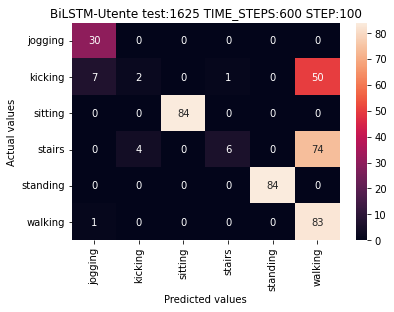

Utente test:  1627
Epoch 1/100
22/22 [==============================] - 16s 322ms/step - loss: 1.7004 - accuracy: 0.2498 - val_loss: 1.5610 - val_accuracy: 0.3168
Epoch 2/100
22/22 [==============================] - 5s 240ms/step - loss: 1.5539 - accuracy: 0.3120 - val_loss: 1.4502 - val_accuracy: 0.3779
Epoch 3/100
22/22 [==============================] - 5s 243ms/step - loss: 1.4561 - accuracy: 0.3702 - val_loss: 1.3606 - val_accuracy: 0.4409
Epoch 4/100
22/22 [==============================] - 5s 250ms/step - loss: 1.3258 - accuracy: 0.4499 - val_loss: 1.1959 - val_accuracy: 0.5069
Epoch 5/100
22/22 [==============================] - 5s 239ms/step - loss: 1.2306 - accuracy: 0.4899 - val_loss: 1.0845 - val_accuracy: 0.5506
Epoch 6/100
22/22 [==============================] - 5s 249ms/step - loss: 1.1077 - accuracy: 0.5386 - val_loss: 0.9448 - val_accuracy: 0.6221
Epoch 7/100
22/22 [==============================] - 5s 250ms/step - loss: 0.9861 - accuracy: 0.5945 - val_loss: 0.8605 - 

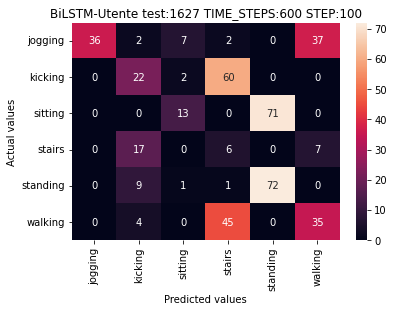

Utente test:  1630
Epoch 1/100
22/22 [==============================] - 15s 321ms/step - loss: 1.6724 - accuracy: 0.2772 - val_loss: 1.5187 - val_accuracy: 0.3491
Epoch 2/100
22/22 [==============================] - 5s 245ms/step - loss: 1.5025 - accuracy: 0.3504 - val_loss: 1.3732 - val_accuracy: 0.4664
Epoch 3/100
22/22 [==============================] - 5s 251ms/step - loss: 1.2978 - accuracy: 0.4515 - val_loss: 1.1261 - val_accuracy: 0.5343
Epoch 4/100
22/22 [==============================] - 6s 251ms/step - loss: 1.1331 - accuracy: 0.5280 - val_loss: 0.9852 - val_accuracy: 0.6182
Epoch 5/100
22/22 [==============================] - 5s 243ms/step - loss: 1.0481 - accuracy: 0.5677 - val_loss: 0.9217 - val_accuracy: 0.5928
Epoch 6/100
22/22 [==============================] - 6s 253ms/step - loss: 1.0292 - accuracy: 0.5720 - val_loss: 0.9812 - val_accuracy: 0.6077
Epoch 7/100
22/22 [==============================] - 5s 240ms/step - loss: 0.9231 - accuracy: 0.6156 - val_loss: 0.9004 - 

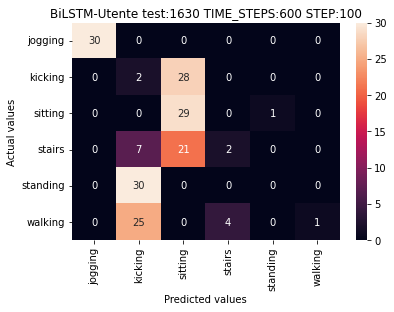

Utente test:  1631
Epoch 1/100
22/22 [==============================] - 16s 323ms/step - loss: 1.6935 - accuracy: 0.2668 - val_loss: 1.5296 - val_accuracy: 0.3320
Epoch 2/100
22/22 [==============================] - 5s 248ms/step - loss: 1.5230 - accuracy: 0.3471 - val_loss: 1.3602 - val_accuracy: 0.4751
Epoch 3/100
22/22 [==============================] - 5s 242ms/step - loss: 1.3162 - accuracy: 0.4616 - val_loss: 1.1928 - val_accuracy: 0.5282
Epoch 4/100
22/22 [==============================] - 6s 255ms/step - loss: 1.2424 - accuracy: 0.4906 - val_loss: 1.0888 - val_accuracy: 0.5470
Epoch 5/100
22/22 [==============================] - 5s 242ms/step - loss: 1.1058 - accuracy: 0.5442 - val_loss: 0.9269 - val_accuracy: 0.6168
Epoch 6/100
22/22 [==============================] - 5s 242ms/step - loss: 1.0055 - accuracy: 0.5755 - val_loss: 0.9421 - val_accuracy: 0.6033
Epoch 7/100
22/22 [==============================] - 6s 252ms/step - loss: 0.9371 - accuracy: 0.6040 - val_loss: 0.8283 - 

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


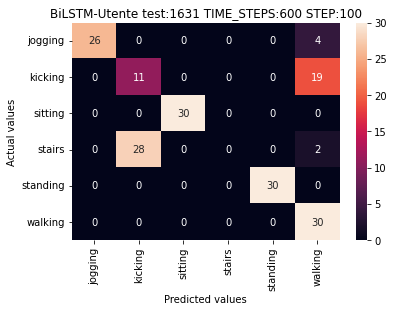

Utente test:  1632
Epoch 1/100
22/22 [==============================] - 15s 325ms/step - loss: 1.7000 - accuracy: 0.2648 - val_loss: 1.5428 - val_accuracy: 0.3273
Epoch 2/100
22/22 [==============================] - 5s 237ms/step - loss: 1.5318 - accuracy: 0.3446 - val_loss: 1.4162 - val_accuracy: 0.4290
Epoch 3/100
22/22 [==============================] - 6s 252ms/step - loss: 1.3717 - accuracy: 0.4351 - val_loss: 1.2375 - val_accuracy: 0.4915
Epoch 4/100
22/22 [==============================] - 6s 253ms/step - loss: 1.2383 - accuracy: 0.4839 - val_loss: 1.0930 - val_accuracy: 0.5786
Epoch 5/100
22/22 [==============================] - 5s 243ms/step - loss: 1.1966 - accuracy: 0.5158 - val_loss: 1.0730 - val_accuracy: 0.5674
Epoch 6/100
22/22 [==============================] - 6s 255ms/step - loss: 1.0865 - accuracy: 0.5591 - val_loss: 0.9368 - val_accuracy: 0.6124
Epoch 7/100
22/22 [==============================] - 5s 242ms/step - loss: 0.9838 - accuracy: 0.6066 - val_loss: 1.0046 - 

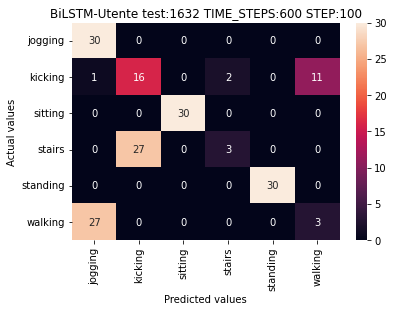

Utente test:  1634
Epoch 1/100
22/22 [==============================] - 16s 328ms/step - loss: 1.7044 - accuracy: 0.2584 - val_loss: 1.5578 - val_accuracy: 0.3647
Epoch 2/100
22/22 [==============================] - 5s 248ms/step - loss: 1.5252 - accuracy: 0.3495 - val_loss: 1.3825 - val_accuracy: 0.4126
Epoch 3/100
22/22 [==============================] - 5s 240ms/step - loss: 1.3752 - accuracy: 0.4260 - val_loss: 1.1875 - val_accuracy: 0.4976
Epoch 4/100
22/22 [==============================] - 5s 246ms/step - loss: 1.2195 - accuracy: 0.4912 - val_loss: 1.0675 - val_accuracy: 0.5786
Epoch 5/100
22/22 [==============================] - 5s 243ms/step - loss: 1.1870 - accuracy: 0.5183 - val_loss: 1.0764 - val_accuracy: 0.5311
Epoch 6/100
22/22 [==============================] - 6s 251ms/step - loss: 1.0819 - accuracy: 0.5456 - val_loss: 0.8918 - val_accuracy: 0.6084
Epoch 7/100
22/22 [==============================] - 6s 253ms/step - loss: 0.9863 - accuracy: 0.5904 - val_loss: 0.8302 - 

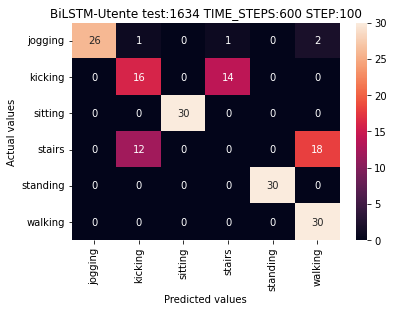

Utente test:  1635
Epoch 1/100
21/21 [==============================] - 16s 398ms/step - loss: 1.7116 - accuracy: 0.2615 - val_loss: 1.5787 - val_accuracy: 0.3270
Epoch 2/100
21/21 [==============================] - 5s 250ms/step - loss: 1.5610 - accuracy: 0.3185 - val_loss: 1.4776 - val_accuracy: 0.3888
Epoch 3/100
21/21 [==============================] - 5s 252ms/step - loss: 1.4397 - accuracy: 0.3809 - val_loss: 1.2560 - val_accuracy: 0.4810
Epoch 4/100
21/21 [==============================] - 5s 243ms/step - loss: 1.2844 - accuracy: 0.4590 - val_loss: 1.1615 - val_accuracy: 0.5089
Epoch 5/100
21/21 [==============================] - 5s 255ms/step - loss: 1.1702 - accuracy: 0.5073 - val_loss: 1.0111 - val_accuracy: 0.5908
Epoch 6/100
21/21 [==============================] - 5s 258ms/step - loss: 1.0929 - accuracy: 0.5522 - val_loss: 1.0105 - val_accuracy: 0.5781
Epoch 7/100
21/21 [==============================] - 5s 247ms/step - loss: 1.0473 - accuracy: 0.5654 - val_loss: 0.9145 - 

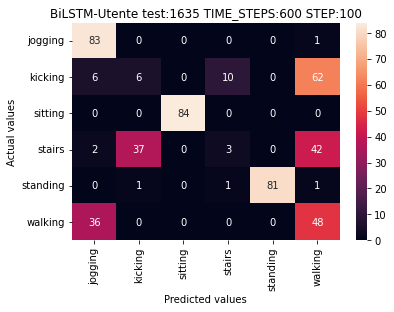

Utente test:  1641
Epoch 1/100
21/21 [==============================] - 15s 370ms/step - loss: 1.6793 - accuracy: 0.2786 - val_loss: 1.5238 - val_accuracy: 0.3523
Epoch 2/100
21/21 [==============================] - 5s 242ms/step - loss: 1.5168 - accuracy: 0.3458 - val_loss: 1.4124 - val_accuracy: 0.4174
Epoch 3/100
21/21 [==============================] - 5s 256ms/step - loss: 1.3286 - accuracy: 0.4392 - val_loss: 1.1674 - val_accuracy: 0.5309
Epoch 4/100
21/21 [==============================] - 5s 248ms/step - loss: 1.2441 - accuracy: 0.4750 - val_loss: 1.1199 - val_accuracy: 0.5580
Epoch 5/100
21/21 [==============================] - 5s 256ms/step - loss: 1.1615 - accuracy: 0.5246 - val_loss: 1.0616 - val_accuracy: 0.5744
Epoch 6/100
21/21 [==============================] - 5s 248ms/step - loss: 1.0801 - accuracy: 0.5612 - val_loss: 0.9620 - val_accuracy: 0.5997
Epoch 7/100
21/21 [==============================] - 5s 245ms/step - loss: 1.0089 - accuracy: 0.5862 - val_loss: 0.9535 - 

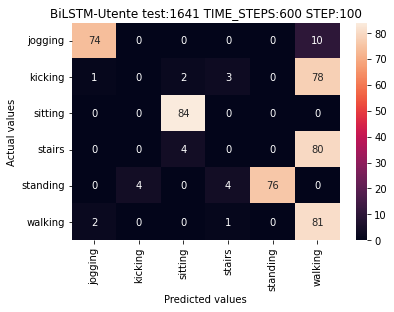

Utente test:  1643
Epoch 1/100
21/21 [==============================] - 15s 370ms/step - loss: 1.6890 - accuracy: 0.2632 - val_loss: 1.5497 - val_accuracy: 0.3296
Epoch 2/100
21/21 [==============================] - 5s 249ms/step - loss: 1.5208 - accuracy: 0.3512 - val_loss: 1.4214 - val_accuracy: 0.4107
Epoch 3/100
21/21 [==============================] - 5s 254ms/step - loss: 1.3565 - accuracy: 0.4302 - val_loss: 1.1771 - val_accuracy: 0.5164
Epoch 4/100
21/21 [==============================] - 5s 245ms/step - loss: 1.2188 - accuracy: 0.4909 - val_loss: 1.2071 - val_accuracy: 0.5164
Epoch 5/100
21/21 [==============================] - 5s 247ms/step - loss: 1.2314 - accuracy: 0.4852 - val_loss: 1.1647 - val_accuracy: 0.5294
Epoch 6/100
21/21 [==============================] - 5s 248ms/step - loss: 1.1563 - accuracy: 0.5236 - val_loss: 1.0150 - val_accuracy: 0.5751
Epoch 7/100
21/21 [==============================] - 5s 257ms/step - loss: 1.0933 - accuracy: 0.5399 - val_loss: 0.9873 - 

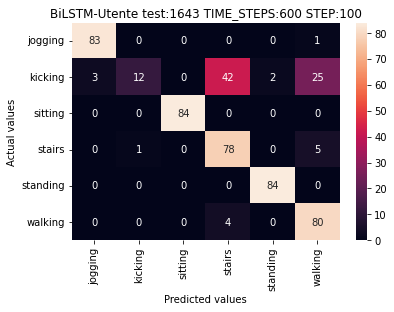

Utente test:  1645
Epoch 1/100
21/21 [==============================] - 16s 353ms/step - loss: 1.6790 - accuracy: 0.2656 - val_loss: 1.5528 - val_accuracy: 0.3173
Epoch 2/100
21/21 [==============================] - 5s 253ms/step - loss: 1.5101 - accuracy: 0.3647 - val_loss: 1.3418 - val_accuracy: 0.4617
Epoch 3/100
21/21 [==============================] - 5s 254ms/step - loss: 1.3176 - accuracy: 0.4612 - val_loss: 1.1646 - val_accuracy: 0.5312
Epoch 4/100
21/21 [==============================] - 5s 247ms/step - loss: 1.1885 - accuracy: 0.5179 - val_loss: 1.0258 - val_accuracy: 0.5833
Epoch 5/100
21/21 [==============================] - 5s 251ms/step - loss: 1.0681 - accuracy: 0.5623 - val_loss: 1.0274 - val_accuracy: 0.5885
Epoch 6/100
21/21 [==============================] - 5s 246ms/step - loss: 1.0735 - accuracy: 0.5602 - val_loss: 0.9351 - val_accuracy: 0.5934
Epoch 7/100
21/21 [==============================] - 5s 253ms/step - loss: 0.9705 - accuracy: 0.5913 - val_loss: 0.8466 - 

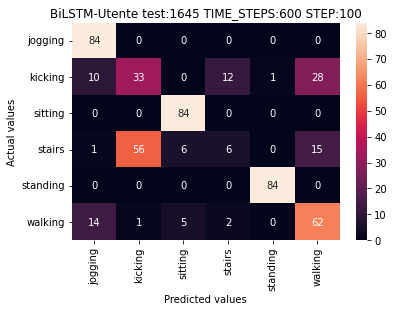

Utente test:  1646
Epoch 1/100
21/21 [==============================] - 16s 352ms/step - loss: 1.6935 - accuracy: 0.2608 - val_loss: 1.5330 - val_accuracy: 0.3497
Epoch 2/100
21/21 [==============================] - 5s 251ms/step - loss: 1.5287 - accuracy: 0.3425 - val_loss: 1.4189 - val_accuracy: 0.4580
Epoch 3/100
21/21 [==============================] - 5s 240ms/step - loss: 1.4087 - accuracy: 0.4121 - val_loss: 1.3318 - val_accuracy: 0.4624
Epoch 4/100
21/21 [==============================] - 5s 254ms/step - loss: 1.2975 - accuracy: 0.4660 - val_loss: 1.2243 - val_accuracy: 0.5175
Epoch 5/100
21/21 [==============================] - 5s 249ms/step - loss: 1.2198 - accuracy: 0.5035 - val_loss: 1.0888 - val_accuracy: 0.5748
Epoch 6/100
21/21 [==============================] - 5s 256ms/step - loss: 1.1177 - accuracy: 0.5450 - val_loss: 0.9582 - val_accuracy: 0.6109
Epoch 7/100
21/21 [==============================] - 5s 257ms/step - loss: 1.0316 - accuracy: 0.5851 - val_loss: 0.9437 - 

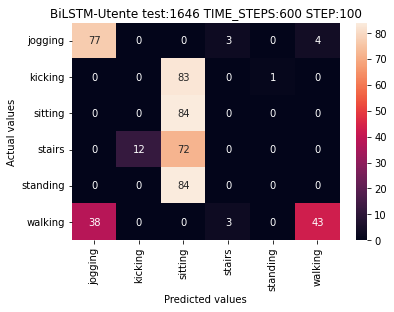

Utente test:  1649
Epoch 1/100
22/22 [==============================] - 15s 328ms/step - loss: 1.6981 - accuracy: 0.2756 - val_loss: 1.5447 - val_accuracy: 0.3699
Epoch 2/100
22/22 [==============================] - 5s 234ms/step - loss: 1.5391 - accuracy: 0.3508 - val_loss: 1.3700 - val_accuracy: 0.4473
Epoch 3/100
22/22 [==============================] - 5s 247ms/step - loss: 1.2981 - accuracy: 0.4692 - val_loss: 1.1297 - val_accuracy: 0.5410
Epoch 4/100
22/22 [==============================] - 5s 240ms/step - loss: 1.1457 - accuracy: 0.5362 - val_loss: 1.0710 - val_accuracy: 0.5538
Epoch 5/100
22/22 [==============================] - 5s 241ms/step - loss: 1.0603 - accuracy: 0.5660 - val_loss: 0.9413 - val_accuracy: 0.6151
Epoch 6/100
22/22 [==============================] - 6s 255ms/step - loss: 0.9958 - accuracy: 0.5851 - val_loss: 0.8540 - val_accuracy: 0.6275
Epoch 7/100
22/22 [==============================] - 5s 243ms/step - loss: 0.9319 - accuracy: 0.6148 - val_loss: 0.8435 - 

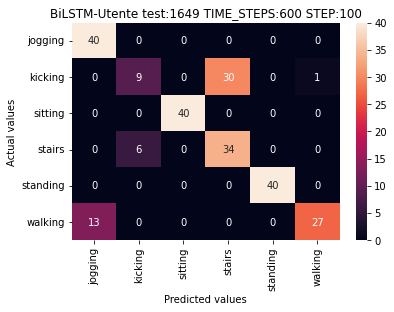

Accuracy media: 0.5929816101420213
F1 media macro: 0.5398233582981644
F1 media weighted: 0.5398233582981644


In [38]:
import itertools
import gc
bilstm_results_dict = []
bilstm_results = pd.DataFrame()

if bilstm_one_subject_out:

    for config in itertools.product(time_steps_list, step_list):

        time_step = config[0]
        step=config[1]

        bilstm_f1_weighted = []
        bilstm_f1_macro = []
        bilstm_acc = []
        bilstm_class_reports = []
        bilstm_confusion_matrixes = []

        print(time_step,step)

        for user_id in users_ids:
          if user_id not in notConsider:

              print("Utente test: ", user_id)

              X_test = np.array(data_cnn[time_step][step][user_id][0])
              y_test = np.array(data_cnn[time_step][step][user_id][1])

              X_train = []
              y_train = []

              for id in users_ids:
                  if id != user_id:
                      X_train += data_cnn[time_step][step][id][0]
                      y_train += data_cnn[time_step][step][id][1]
            
              X_train = np.array(X_train)
              y_train = np.array(y_train)

              y_train = enc.transform(y_train)
              y_test = enc.transform(y_test)

              scaler = RobustScaler()
              X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
              X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
            
            #X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
            #X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

              model = createBiLSTM([X_train[0].shape[0], X_train[0].shape[1]], y_train[0].shape[0])

              callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=True, restore_best_weights=True)

              XTraining, XValidation, YTraining, YValidation = train_test_split(X_train,y_train,stratify=y_train,test_size=0.2)

              model.fit(XTraining, YTraining, batch_size = batchsize, epochs = 100, validation_data=(XValidation,YValidation), verbose=1, callbacks=[callback], shuffle=True )
            
              rounded_labels=np.argmax(y_test, axis=1)
              y_pred = np.argmax(model.predict(X_test), axis=-1)

              bilstm_acc.append(accuracy_score(rounded_labels, y_pred))
              bilstm_f1_weighted.append(f1_score(rounded_labels, y_pred, average='weighted'))
              bilstm_f1_macro.append(f1_score(rounded_labels, y_pred, average='macro'))
            #bilstm_f1.append(f1_m(rounded_labels,y_pred))

              class_report = classification_report(rounded_labels, y_pred, digits=4)
              print(class_report)
              bilstm_class_reports.append(class_report)
            
              conf_matrix = confusion_matrix(rounded_labels, y_pred, labels=range(0,len(enc.categories_[0])))

              ax = seaborn.heatmap(conf_matrix, annot=True, fmt='d')

              ax.set_title("BiLSTM-Utente test:" + str(user_id) + " TIME_STEPS:"+str(time_step)+" STEP:"+str(step))

              ax.set_xlabel('Predicted values')
              ax.set_ylabel('Actual values')

              ax.xaxis.set_ticklabels(enc.categories_[0].tolist(), rotation=90)
              ax.yaxis.set_ticklabels(enc.categories_[0].tolist(), rotation=0)

              ax.get_figure().savefig(bilstm_plot_dir+'/'+ax.get_title().replace(":"," ")+".png", dpi=500)

              bilstm_confusion_matrixes.append(ax)
              plt.show()

              gc.collect()





            

        print("Accuracy media:",np.mean(bilstm_acc))
        print("F1 media macro:",np.mean(bilstm_f1_macro))
        print("F1 media weighted:",np.mean(bilstm_f1_macro))

        bilstm_results_dict.append({
            'Time Steps':time_step,
            'Step':step,
            'Average accuracy':np.mean(bilstm_acc),
            'Average F1 weighted': np.mean(bilstm_f1_weighted),
            'Average F1 macro': np.mean(bilstm_f1_macro),
            'reports':bilstm_class_reports,
            'confusion_matrix':bilstm_confusion_matrixes
        })

    bilstm_config_file = open(bilstm_config_filename, "a")
    model.summary(print_fn=lambda x: bilstm_config_file.write(x))
    bilstm_config_file.close()

In [39]:
bilstm_results_dataframe = pd.DataFrame(bilstm_results_dict)
bilstm_results_dataframe.to_csv(bilstm_result_filename)
bilstm_results_dataframe

,Time Steps,Step,Average accuracy,Average F1 weighted,Average F1 macro,reports,confusion_matrix
0,600,100,0.592982,0.539775,0.539823,[ precision recall f1-score ...,"[AxesSubplot(0.125,0.125;0.62x0.755), AxesSubp..."


# SHALLOW LEARNING

## Random Forest

In [ ]:
rf_dir = folder_name + "\\rf"
plot_dir = "\\plot"
result_filename = "\\result.csv"
config_filename = "\\config.txt"

try:
    mkdir(rf_dir )
    mkdir(rf_dir + plot_dir)
except OSError as error:
    print(error)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   33.1s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 10.7min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:    0.4s finished


              precision    recall  f1-score   support

     jogging       1.00      1.00      1.00        30
     kicking       1.00      1.00      1.00        30
     sitting       1.00      1.00      1.00        30
      stairs       1.00      0.93      0.97        30
    standing       1.00      1.00      1.00        30
     walking       0.94      1.00      0.97        30

    accuracy                           0.99       180
   macro avg       0.99      0.99      0.99       180
weighted avg       0.99      0.99      0.99       180

f1:  0.9888765294771968
acc:  0.9888888888888889


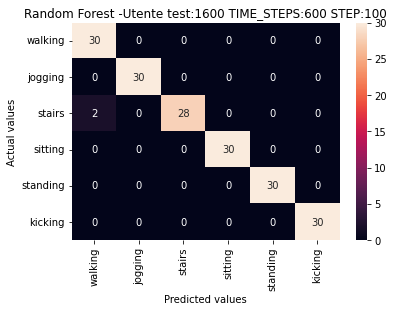

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   31.7s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 10.7min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:    0.3s finished


              precision    recall  f1-score   support

     jogging       1.00      1.00      1.00        30
     kicking       1.00      0.40      0.57        30
     sitting       1.00      1.00      1.00        30
      stairs       0.33      0.10      0.15        30
    standing       1.00      1.00      1.00        30
     walking       0.38      0.87      0.53        30

    accuracy                           0.73       180
   macro avg       0.79      0.73      0.71       180
weighted avg       0.79      0.73      0.71       180

f1:  0.7084212084212085
acc:  0.7277777777777777


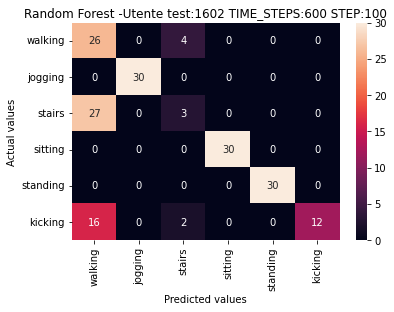

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   29.3s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 10.8min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:    0.3s finished


              precision    recall  f1-score   support

     jogging       1.00      1.00      1.00        30
     kicking       1.00      0.97      0.98        30
     sitting       0.86      1.00      0.92        30
      stairs       0.90      0.93      0.92        30
    standing       1.00      0.83      0.91        30
     walking       0.93      0.93      0.93        30

    accuracy                           0.94       180
   macro avg       0.95      0.94      0.94       180
weighted avg       0.95      0.94      0.94       180

f1:  0.9444307999740065
acc:  0.9444444444444444


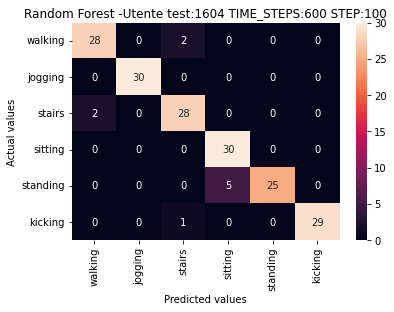

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.0s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 10.6min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:    0.4s finished


              precision    recall  f1-score   support

     jogging       1.00      1.00      1.00        40
     kicking       0.73      0.93      0.81        40
     sitting       0.95      1.00      0.98        40
      stairs       0.90      0.23      0.36        40
    standing       1.00      0.95      0.97        40
     walking       0.66      0.97      0.79        40

    accuracy                           0.85       240
   macro avg       0.87      0.85      0.82       240
weighted avg       0.87      0.85      0.82       240

f1:  0.8185057219203562
acc:  0.8458333333333333


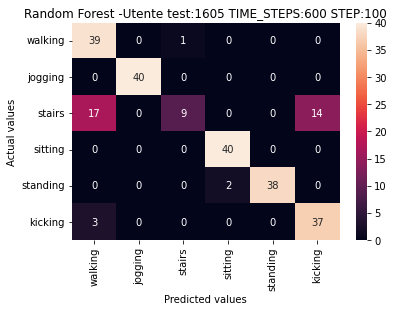

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   28.3s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 10.6min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:    0.3s finished
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Us

              precision    recall  f1-score   support

     jogging       1.00      1.00      1.00        30
     kicking       0.92      0.73      0.81        30
     sitting       0.50      1.00      0.67        30
      stairs       0.45      1.00      0.62        30
    standing       0.00      0.00      0.00        30
     walking       0.00      0.00      0.00        30

    accuracy                           0.62       180
   macro avg       0.48      0.62      0.52       180
weighted avg       0.48      0.62      0.52       180

f1:  0.5177469135802469
acc:  0.6222222222222222


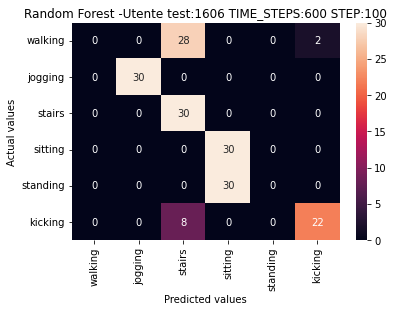

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   29.8s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 10.6min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:    0.5s finished


              precision    recall  f1-score   support

     jogging       1.00      1.00      1.00        35
     kicking       1.00      0.51      0.68        84
     sitting       1.00      1.00      1.00        30
      stairs       0.64      0.23      0.34        30
    standing       1.00      1.00      1.00        30
     walking       0.33      1.00      0.50        30

    accuracy                           0.73       239
   macro avg       0.83      0.79      0.75       239
weighted avg       0.87      0.73      0.74       239

f1:  0.741112101266962
acc:  0.7322175732217573


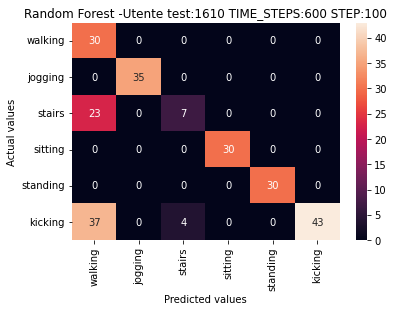

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   29.9s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 10.6min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:    0.4s finished


              precision    recall  f1-score   support

     jogging       0.54      1.00      0.70        30
     kicking       0.54      1.00      0.70        30
     sitting       0.91      1.00      0.95        30
      stairs       1.00      0.67      0.80        30
    standing       1.00      0.03      0.06        30
     walking       0.29      0.13      0.18        30

    accuracy                           0.64       180
   macro avg       0.71      0.64      0.57       180
weighted avg       0.71      0.64      0.57       180

f1:  0.5656773500734491
acc:  0.6388888888888888


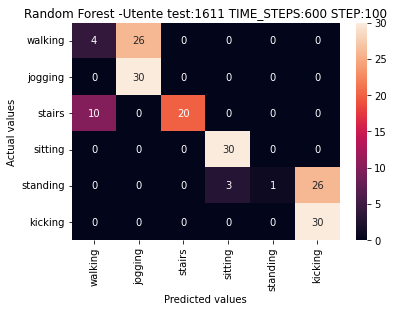

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   27.6s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 10.3min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:    0.5s finished
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Us

              precision    recall  f1-score   support

     jogging       1.00      1.00      1.00        85
     kicking       0.45      0.91      0.60        85
     sitting       1.00      1.00      1.00        85
      stairs       1.00      0.51      0.67        85
    standing       0.00      0.00      0.00        85
     walking       0.68      1.00      0.81        85

    accuracy                           0.74       510
   macro avg       0.69      0.74      0.68       510
weighted avg       0.69      0.74      0.68       510

f1:  0.6801034332345129
acc:  0.7352941176470589


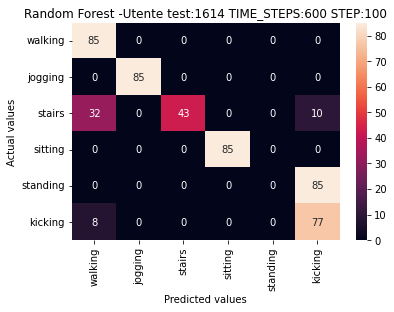

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   28.4s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 10.7min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:    0.3s finished


              precision    recall  f1-score   support

     jogging       0.62      1.00      0.77        30
     kicking       1.00      0.93      0.97        30
     sitting       1.00      1.00      1.00        30
      stairs       0.17      0.03      0.06        30
    standing       1.00      1.00      1.00        30
     walking       0.71      0.90      0.79        30

    accuracy                           0.81       180
   macro avg       0.75      0.81      0.76       180
weighted avg       0.75      0.81      0.76       180

f1:  0.7640702022040765
acc:  0.8111111111111111


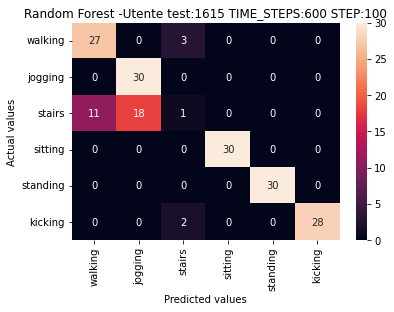

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   28.3s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 10.6min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:    0.4s finished
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_

              precision    recall  f1-score   support

     jogging       0.00      0.00      0.00         0
     kicking       0.87      0.90      0.89        84
     sitting       0.94      1.00      0.97        30
      stairs       0.85      0.54      0.66        84
    standing       1.00      0.93      0.97        30
     walking       0.67      0.75      0.71        77

    accuracy                           0.78       305
   macro avg       0.72      0.69      0.70       305
weighted avg       0.84      0.78      0.80       305

f1:  0.7955556384808421
acc:  0.7770491803278688


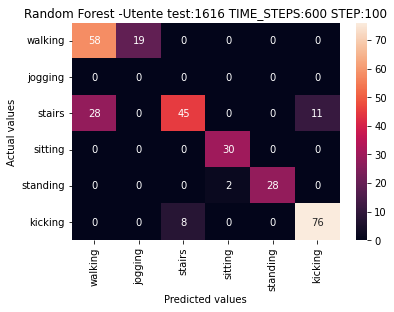

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   28.0s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 10.6min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:    0.4s finished


              precision    recall  f1-score   support

     jogging       1.00      1.00      1.00        30
     kicking       1.00      1.00      1.00        30
     sitting       0.86      1.00      0.92        30
      stairs       0.97      1.00      0.98        30
    standing       1.00      0.94      0.97        84
     walking       1.00      0.97      0.98        30

    accuracy                           0.97       234
   macro avg       0.97      0.98      0.98       234
weighted avg       0.98      0.97      0.97       234

f1:  0.9748518919691606
acc:  0.9743589743589743


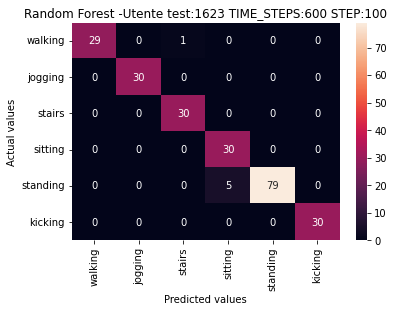

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   27.8s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 10.5min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:    0.4s finished


              precision    recall  f1-score   support

     jogging       1.00      0.83      0.91        30
     kicking       1.00      0.48      0.65        60
     sitting       1.00      1.00      1.00        84
      stairs       0.70      0.99      0.82        84
    standing       1.00      1.00      1.00        84
     walking       0.97      0.99      0.98        84

    accuracy                           0.91       426
   macro avg       0.94      0.88      0.89       426
weighted avg       0.93      0.91      0.90       426

f1:  0.9047584113856683
acc:  0.9107981220657277


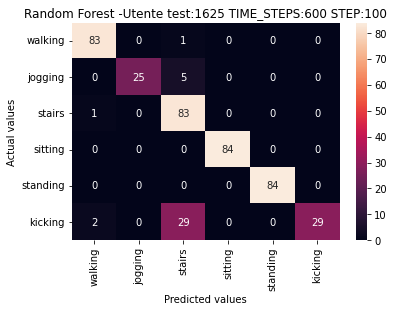

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   29.6s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 10.7min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:    0.4s finished


              precision    recall  f1-score   support

     jogging       1.00      0.92      0.96        84
     kicking       0.86      0.99      0.92        84
     sitting       0.50      0.06      0.11        84
      stairs       0.97      1.00      0.98        30
    standing       0.47      0.83      0.60        83
     walking       0.98      1.00      0.99        84

    accuracy                           0.78       449
   macro avg       0.79      0.80      0.76       449
weighted avg       0.77      0.78      0.73       449

f1:  0.731463357114657
acc:  0.7750556792873051


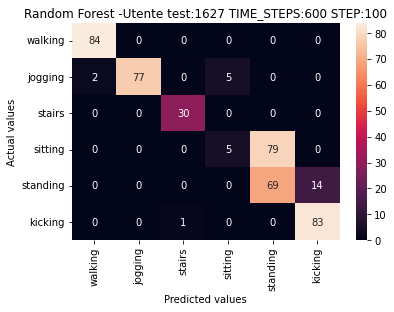

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   28.3s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 10.7min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:    0.3s finished


              precision    recall  f1-score   support

     jogging       1.00      1.00      1.00        30
     kicking       1.00      0.97      0.98        30
     sitting       0.39      0.67      0.49        30
      stairs       0.91      0.97      0.94        30
    standing       0.00      0.00      0.00        30
     walking       0.96      0.90      0.93        30

    accuracy                           0.75       180
   macro avg       0.71      0.75      0.72       180
weighted avg       0.71      0.75      0.72       180

f1:  0.7238993936129694
acc:  0.75


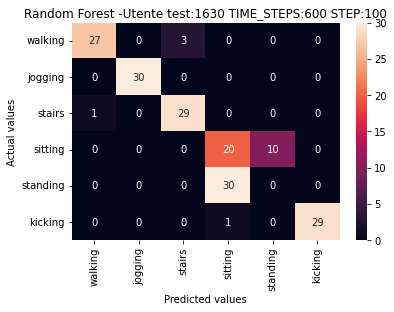

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.1s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 10.7min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:    0.4s finished


              precision    recall  f1-score   support

     jogging       1.00      1.00      1.00        30
     kicking       1.00      0.93      0.97        30
     sitting       1.00      1.00      1.00        30
      stairs       1.00      0.07      0.12        30
    standing       1.00      1.00      1.00        30
     walking       0.50      1.00      0.67        30

    accuracy                           0.83       180
   macro avg       0.92      0.83      0.79       180
weighted avg       0.92      0.83      0.79       180

f1:  0.7928639846743295
acc:  0.8333333333333334


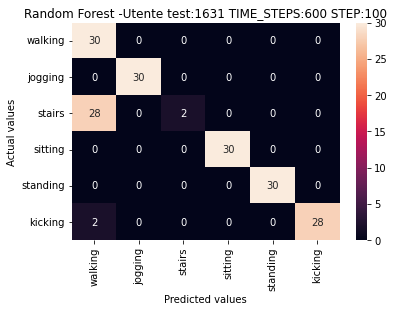

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.1s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 10.8min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:    0.5s finished


              precision    recall  f1-score   support

     jogging       0.91      1.00      0.95        30
     kicking       1.00      0.77      0.87        30
     sitting       1.00      1.00      1.00        30
      stairs       0.94      1.00      0.97        30
    standing       1.00      1.00      1.00        30
     walking       0.94      1.00      0.97        30

    accuracy                           0.96       180
   macro avg       0.96      0.96      0.96       180
weighted avg       0.96      0.96      0.96       180

f1:  0.9592982252750968
acc:  0.9611111111111111


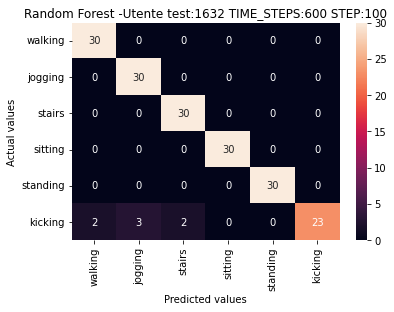

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   28.4s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 10.7min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:    0.4s finished


              precision    recall  f1-score   support

     jogging       1.00      1.00      1.00        30
     kicking       1.00      0.93      0.97        30
     sitting       1.00      1.00      1.00        30
      stairs       0.71      0.17      0.27        30
    standing       1.00      1.00      1.00        30
     walking       0.55      1.00      0.71        30

    accuracy                           0.85       180
   macro avg       0.88      0.85      0.82       180
weighted avg       0.88      0.85      0.82       180

f1:  0.8236116440984597
acc:  0.85


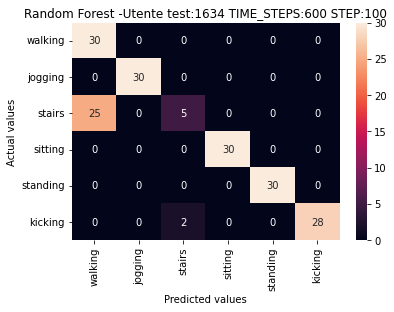

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   29.8s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 10.5min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:    0.6s finished


              precision    recall  f1-score   support

     jogging       0.99      1.00      0.99        84
     kicking       0.96      0.98      0.97        84
     sitting       1.00      1.00      1.00        84
      stairs       1.00      0.17      0.29        84
    standing       1.00      0.96      0.98        84
     walking       0.54      1.00      0.70        84

    accuracy                           0.85       504
   macro avg       0.92      0.85      0.82       504
weighted avg       0.92      0.85      0.82       504

f1:  0.8224930632075789
acc:  0.8511904761904762


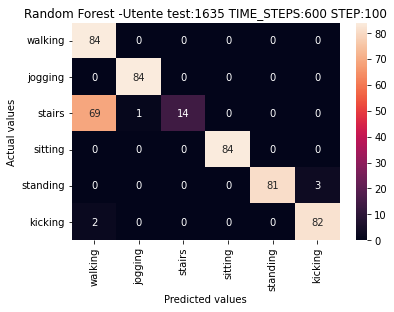

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   27.8s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 10.5min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:    0.6s finished


              precision    recall  f1-score   support

     jogging       0.97      1.00      0.98        84
     kicking       0.97      0.68      0.80        84
     sitting       1.00      0.43      0.60        84
      stairs       1.00      0.52      0.69        84
    standing       0.63      0.98      0.77        84
     walking       0.57      1.00      0.72        84

    accuracy                           0.77       504
   macro avg       0.85      0.77      0.76       504
weighted avg       0.85      0.77      0.76       504

f1:  0.7596086681291789
acc:  0.7678571428571429


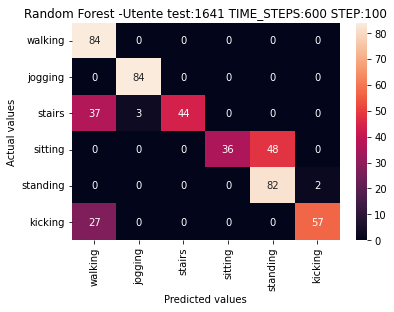

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   29.1s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 10.4min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:    0.6s finished


              precision    recall  f1-score   support

     jogging       0.99      1.00      0.99        84
     kicking       1.00      0.61      0.76        84
     sitting       1.00      1.00      1.00        84
      stairs       0.73      0.98      0.84        84
    standing       1.00      1.00      1.00        84
     walking       0.95      1.00      0.98        84

    accuracy                           0.93       504
   macro avg       0.95      0.93      0.93       504
weighted avg       0.95      0.93      0.93       504

f1:  0.927186212619384
acc:  0.9305555555555556


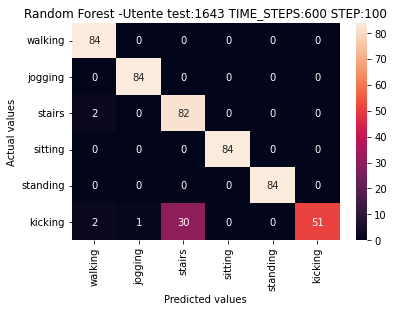

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   27.6s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 10.4min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:    0.4s finished


              precision    recall  f1-score   support

     jogging       0.86      1.00      0.92        84
     kicking       0.98      0.58      0.73        84
     sitting       1.00      1.00      1.00        84
      stairs       0.73      0.70      0.72        84
    standing       1.00      1.00      1.00        84
     walking       0.78      0.99      0.87        84

    accuracy                           0.88       504
   macro avg       0.89      0.88      0.87       504
weighted avg       0.89      0.88      0.87       504

f1:  0.8731136115757511
acc:  0.878968253968254


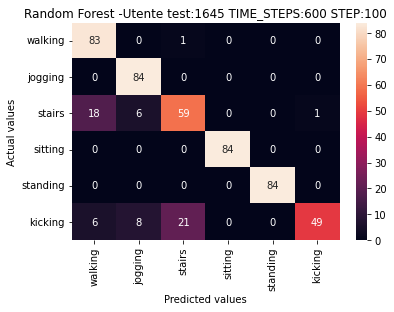

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   29.3s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 10.3min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:    0.5s finished


              precision    recall  f1-score   support

     jogging       0.93      0.94      0.93        84
     kicking       0.97      0.92      0.94        84
     sitting       0.67      0.95      0.78        84
      stairs       0.92      0.98      0.95        84
    standing       0.80      0.52      0.63        84
     walking       0.99      0.89      0.94        84

    accuracy                           0.87       504
   macro avg       0.88      0.87      0.86       504
weighted avg       0.88      0.87      0.86       504

f1:  0.8637634413266564
acc:  0.8670634920634921


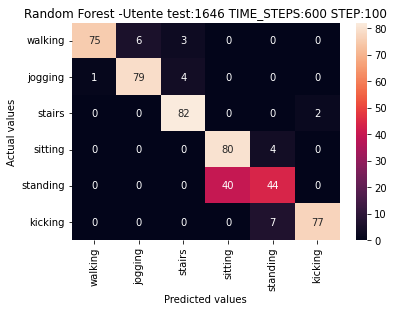

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   29.8s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 10.6min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:    0.4s finished


              precision    recall  f1-score   support

     jogging       0.83      1.00      0.91        40
     kicking       1.00      0.95      0.97        40
     sitting       1.00      1.00      1.00        40
      stairs       0.97      0.88      0.92        40
    standing       1.00      1.00      1.00        40
     walking       0.84      0.80      0.82        40

    accuracy                           0.94       240
   macro avg       0.94      0.94      0.94       240
weighted avg       0.94      0.94      0.94       240

f1:  0.9375025559236084
acc:  0.9375


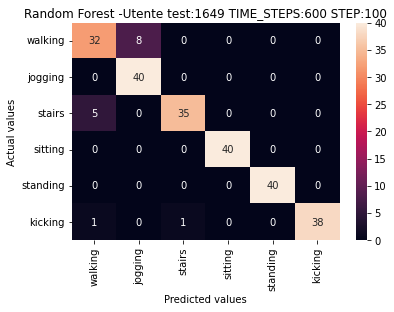

F1 total:  0.8095180156324069
Accuracy total:  0.8309356382023793
   Time Steps  Step  Average accuracy  Average F1
0         600   100          0.830936    0.809518


In [ ]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

rf_results = []

gc.collect()
for config in itertools.product(time_steps_list, step_list):



    time_step = config[0]
    step=config[1]

    tuple = tuple_by_timestep[time_steps][step]

    f1_list = []
    acc_list = []

    for user_id in users_ids:
      if user_id not in notConsider:

        x_test = tuple[user_id][0]
        y_test = tuple[user_id][1]

        x_train = []
        y_train = []

        for id in users_ids:
            if id != user_id:
                x_train+=tuple[id][0]
                y_train+=tuple[id][1]
        
        x_train = [x_train[i].flatten() for i in range(len(x_train)) ]
        x_test = [x_test[i].flatten() for i in range(len(x_test))]

        y_train = np.array(y_train).flatten()
        y_test = np.array(y_test).flatten()

        scaler = MinMaxScaler()
        x_train = scaler.fit_transform(x_train)
        x_test = scaler.transform(x_test)

        model = RandomForestClassifier(n_jobs=-1,n_estimators=1000,random_state=seed, verbose=True)

        model.fit(x_train, y_train)

        y_pred = model.predict(x_test)

        conf_mat = confusion_matrix(y_test, y_pred, labels=classes)

        f1 = f1_score(y_test, y_pred, average='weighted')
        acc = accuracy_score(y_test, y_pred)

        print(classification_report(y_test, y_pred))

        ax = seaborn.heatmap(conf_mat, annot=True, fmt='d')

        ax.set_title("Random Forest -Utente test:" + str(user_id) + " TIME_STEPS:"+str(time_step)+" STEP:"+str(step))
        ax.get_figure().savefig(rf_dir+plot_dir+'/'+ax.get_title().replace(":"," ")+".png", dpi=500)
        ax.set_xlabel('Predicted values')
        ax.set_ylabel('Actual values')

        ax.xaxis.set_ticklabels(classes, rotation=90)
        ax.yaxis.set_ticklabels(classes, rotation=0)


        print("f1: ", f1)
        print("acc: ", acc)

        f1_list.append(f1)
        acc_list.append(acc)


        plt.show()
    
    print("F1 total: ", np.mean(f1_list))
    print("Accuracy total: ", np.mean(acc_list))

    rf_results.append({
    'Time Steps':time_step,
    'Step':step,
    'Average accuracy':np.mean(acc_list),
    'Average F1': np.mean(f1_list),
    })

rf_results_df = pd.DataFrame(rf_results)
rf_results_df.to_csv(rf_dir + result_filename)
print(rf_results_df)
